In [291]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from os import listdir
from tqdm import tqdm
import seaborn as sns

%config InlineBackend.figure_format='retina'

## Determinist Tourist Walk Implementation

In [5]:
G = nx.Graph()

G.add_edge(0,"A")
G.add_edge("C","A")
G.add_edge("C",1)
G.add_edge("C",2)
G.add_edge("C",3)
G.add_edge(0,2)

G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(3,4)
G.add_edge(3,2)
G.add_edge(3,1)
G.add_edge(4,1)

nx.draw_networkx(G, with_labels=True)

In [286]:
class Tourist:
    def __init__(self, graph, initial_city, u=1, z=5):
        self.memory_size = u
        self.maximum_cities_visited = u+z
        self.memory = []
        self.cities_visited = []

        self.current_city = initial_city
        self.cities_visited = [initial_city]
        self.graph = graph

        self.transient = []
        self.attractor = []

        # 0 -> Not initialized
        # 1 -> Running
        # 2 -> Stopped
        self.status = 0

    def stop(self):
        self.status = 2

        if (len(self.attractor) == 0):
            self.transient = self.cities_visited
        
        print("The tourist has stopped")
        print("Number of cities visited: ", len(self.cities_visited))
        print("Memory: ", self.memory)
        print("Current City: ", self.current_city)
        print("Cities visited: ", self.cities_visited)
        print("Transient: ", self.transient)
        print("Attractor: ", self.attractor)
        
    def travel(self):
        self.save_city_to_memory(self.current_city)
                
        possible_destinations = [*map(lambda x: x[1], self.graph.edges(self.current_city))]
        possible_destinations = [*filter(lambda x: x not in self.memory, possible_destinations)]

        if (len(possible_destinations) == 0):
            print("No possible destination\n")
            self.stop()

        else:
            destination = self.choose_next_city(possible_destinations)
            self.current_city = destination
            self.cities_visited.append(destination)
        
    def choose_next_city(self, possible_destinations):
        return random.choice(possible_destinations)

    def save_city_to_memory(self, city):
        if (len(self.memory) >= self.memory_size):
            self.memory = self.memory[1:]

        self.memory.append(city)

    def detect_attractor(self):
        path = dict()

        for i in range(len(self.cities_visited)):
            if (self.cities_visited[i] not in path):
                path[self.cities_visited[i]] = []
                
            path[self.cities_visited[i]].append(i)

        for key in path.keys():
            if (len(path[key]) > 1):
                path[key] = path[key][-1] - path[key][-2]
            else: 
                path[key] = 0

        reversed_path = [*reversed(path.keys())]
        possible_attractor = []
        transient = []
        
        if (path[reversed_path[0]] == 0):
            return
        
        for node in reversed_path:
            if (path[node] != path[reversed_path[0]] or len(transient)>1):
                transient.append(node)
            else:
                possible_attractor.append(node)

        if (len(possible_attractor) >= self.memory_size+1):
            print("Stuck to an attractor\n")
            self.attractor = [*reversed(possible_attractor)]
            self.transient = [*reversed(transient)]
            
            self.stop()
    
    def run(self):
        if (self.status != 0):
            return self.stop()
            
        self.status = 1
        
        while (self.status == 1):
            self.detect_attractor()
            
            if (len(self.cities_visited) < self.maximum_cities_visited):
                self.travel()
            else:
                print("Visited maximum allowed cities\n")
                self.stop()
        
        results = dict()
        results['transient'] = self.transient
        results['attractor'] = self.attractor
        
        return results

In [7]:
class TouristSmallestDegree(Tourist):
    def choose_next_city(self, possible_destinations):
        
        possible_destinations.sort(key=self.graph.degree)
        
        return possible_destinations[0]

In [8]:
class TouristHighestDegree(Tourist):
    def choose_next_city(self, possible_destinations):
        
        possible_destinations.sort(key=self.graph.degree)
        
        return possible_destinations[-1]

### Examples:

In [9]:
agent = TouristSmallestDegree(G, 0, u=2, z=10)
agent.run()

{'transient': [0, 'A', 'C', 1, 4, 3, 'C', 'A', 0, 2, 'C', 'A'],
 'attractor': []}

In [10]:
agent = TouristSmallestDegree(G, 0, u=1, z=100)
agent.run()

{'transient': [], 'attractor': [0, 'A']}

## Using a network

In [11]:
def open_network(file):
    lines = open(file, "r").read().split("\n")
    N = nx.Graph()

    for line in lines:
        network_array = line.split(" ")
        
        for x in network_array[1:]:
            N.add_edge(network_array[0], x)

    return N

In [12]:
N = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=1.txt")

fig, axs = plt.subplots(figsize=(14,14))
nx.draw_networkx(N, with_labels=True, node_size=700, node_color='#89CFF0', font_size=8)

In [36]:
for node in N.nodes():
    agent = TouristSmallestDegree(N, node, u=1, z=590)
    agent.run()

Transient:  []
Attractor:  ['182', '181']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  11
Memory:  ['84']
Current City:  82
Cities visited:  ['97', '95', '94', '92', '90', '88', '86', '84', '82', '84', '82']
Transient:  ['97', '95', '94', '92', '90', '88', '86']
Attractor:  ['84', '82']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  7
Memory:  ['219']
Current City:  232
Cities visited:  ['224', '223', '221', '219', '232', '219', '232']
Transient:  ['224', '223', '221']
Attractor:  ['219', '232']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  7
Memory:  ['238']
Current City:  237
Cities visited:  ['395', '241', '240', '238', '237', '238', '237']
Transient:  ['395', '241', '240']
Attractor:  ['238', '237']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  6
Memory:  ['117']
Current City:  115
Cities visited:  ['120', '119', '117', '115', '117', '115']
Transient:  ['120', '119']
Attr

Cities visited:  ['380', '378', '376', '375', '20', '19', '18', '197', '18', '197']
Transient:  ['380', '378', '376', '375', '20', '19']
Attractor:  ['18', '197']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  11
Memory:  ['18']
Current City:  197
Cities visited:  ['381', '379', '378', '376', '375', '20', '19', '18', '197', '18', '197']
Transient:  ['381', '379', '378', '376', '375', '20', '19']
Attractor:  ['18', '197']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  5
Memory:  ['270']
Current City:  268
Cities visited:  ['271', '270', '268', '270', '268']
Transient:  ['271']
Attractor:  ['270', '268']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  5
Memory:  ['358']
Current City:  360
Cities visited:  ['357', '358', '360', '358', '360']
Transient:  ['357']
Attractor:  ['358', '360']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  5
Memory:  ['277']
Current City:  278
Cities visit

In [288]:
for node in N.nodes():
    agent = Tourist(N, node, u=3, z=590)
    agent.run()

No possible destination

The tourist has stopped
Number of cities visited:  578
Memory:  ['374', '372', '373']
Current City:  373
Cities visited:  ['0', '2', '4', '488', '487', '489', '491', '76', '74', '75', '73', '71', '70', '68', '297', '296', '298', '299', '301', '239', '237', '238', '240', '239', '301', '302', '303', '277', '276', '275', '132', '133', '135', '134', '132', '131', '133', '134', '136', '137', '138', '140', '142', '143', '145', '480', '211', '296', '294', '292', '293', '291', '289', '290', '292', '293', '291', '290', '289', '287', '286', '288', '289', '290', '292', '294', '295', '293', '291', '366', '365', '363', '362', '476', '210', '211', '480', '145', '143', '142', '140', '138', '136', '137', '203', '204', '205', '207', '208', '102', '100', '98', '96', '496', '497', '93', '390', '392', '391', '389', '388', '390', '22', '24', '23', '21', '19', '20', '375', '377', '376', '378', '380', '381', '379', '378', '377', '321', '322', '320', '319', '3', '2', '0', '499', '1', 

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['472', '470', '468']
Current City:  467
Cities visited:  ['497', '496', '96', '95', '97', '395', '394', '385', '383', '384', '386', '228', '227', '225', '226', '228', '227', '229', '42', '43', '44', '440', '439', '438', '436', '425', '424', '423', '421', '420', '422', '424', '423', '425', '427', '428', '426', '424', '425', '427', '429', '431', '433', '435', '434', '436', '438', '437', '442', '443', '441', '439', '440', '44', '46', '45', '43', '41', '497', '499', '1', '2', '4', '231', '230', '111', '113', '112', '110', '108', '107', '106', '201', '202', '200', '199', '201', '202', '204', '203', '201', '202', '204', '205', '207', '208', '209', '371', '372', '373', '374', '38', '40', '41', '43', '45', '46', '44', '43', '45', '46', '44', '43', '41', '497', '93', '94', '92', '91', '89', '87', '88', '86', '84', '82', '22', '20', '375', '377', '321', '323', '322', '320', '318', '193', '194', '192'

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['74', '72', '73']
Current City:  71
Cities visited:  ['488', '4', '3', '1', '2', '0', '499', '163', '162', '161', '87', '88', '89', '91', '93', '94', '92', '490', '182', '180', '109', '107', '106', '104', '103', '102', '100', '99', '98', '97', '95', '96', '98', '97', '395', '393', '392', '394', '396', '397', '399', '269', '270', '268', '50', '49', '47', '261', '263', '262', '260', '259', '242', '241', '240', '239', '301', '303', '302', '25', '24', '60', '248', '250', '252', '386', '385', '400', '401', '403', '405', '404', '406', '407', '405', '404', '406', '467', '83', '81', '80', '78', '79', '200', '198', '197', '195', '193', '191', '202', '204', '203', '201', '200', '198', '199', '114', '116', '115', '113', '114', '112', '110', '108', '107', '109', '492', '206', '207', '205', '412', '410', '317', '316', '314', '315', '317', '316', '318', '193', '195', '197', '18', '19', '20', '22', '24', 

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['359', '325', '323']
Current City:  324
Cities visited:  ['236', '354', '84', '86', '212', '214', '213', '215', '217', '216', '167', '168', '169', '349', '400', '401', '403', '405', '407', '406', '467', '468', '469', '471', '472', '473', '116', '115', '117', '119', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '267', '269', '399', '398', '246', '244', '243', '245', '247', '246', '216', '167', '165', '164', '166', '37', '36', '35', '34', '338', '339', '341', '340', '342', '213', '211', '210', '208', '206', '192', '190', '189', '444', '446', '445', '447', '449', '448', '446', '447', '445', '443', '444', '189', '191', '193', '192', '194', '195', '196', '198', '199', '200', '201', '106', '107', '108', '110', '112', '111', '487', '486', '488', '4', '2', '0', '1', '3', '235', '236', '234', '233', '272', '274', '273', '356', '354', '236', '234', '478', '477', '475', 

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['204', '203', '201']
Current City:  200
Cities visited:  ['486', '485', '78', '79', '200', '201', '203', '137', '138', '136', '134', '133', '135', '136', '134', '132', '275', '276', '7', '48', '50', '448', '449', '450', '452', '453', '454', '180', '179', '457', '456', '458', '387', '385', '214', '213', '211', '210', '212', '450', '452', '451', '453', '454', '452', '450', '449', '451', '452', '454', '478', '416', '417', '305', '152', '153', '151', '150', '148', '307', '308', '309', '310', '311', '279', '278', '280', '282', '307', '148', '149', '150', '151', '153', '154', '152', '150', '148', '147', '149', '151', '150', '152', '154', '153', '151', '149', '147', '148', '307', '282', '281', '283', '284', '282', '307', '308', '310', '312', '313', '315', '316', '317', '410', '412', '205', '206', '492', '109', '107', '105', '103', '101', '99', '100', '98', '354', '356', '357', '355', '306', '30', 

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['385', '394', '396']
Current City:  397
Cities visited:  ['328', '327', '329', '5', '6', '4', '3', '319', '318', '193', '194', '192', '191', '202', '204', '203', '137', '136', '138', '140', '141', '474', '472', '473', '412', '205', '206', '207', '209', '208', '102', '104', '106', '108', '107', '109', '185', '187', '189', '190', '192', '206', '208', '210', '211', '480', '356', '357', '358', '359', '361', '362', '476', '475', '477', '478', '234', '233', '232', '219', '220', '218', '352', '351', '349', '348', '350', '351', '352', '218', '484', '483', '481', '479', '480', '145', '143', '144', '142', '484', '218', '352', '350', '351', '349', '400', '401', '402', '403', '405', '407', '176', '177', '178', '180', '181', '183', '184', '186', '188', '187', '185', '184', '183', '181', '182', '490', '491', '492', '225', '224', '222', '220', '218', '352', '354', '356', '273', '271', '269', '399', '398',

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['457', '459', '254']
Current City:  256
Cities visited:  ['46', '44', '43', '45', '46', '404', '406', '17', '19', '21', '23', '24', '25', '26', '411', '154', '155', '157', '149', '150', '151', '153', '175', '160', '161', '87', '89', '88', '90', '92', '94', '93', '390', '391', '389', '388', '390', '22', '20', '19', '21', '272', '233', '234', '235', '236', '238', '240', '241', '395', '396', '398', '399', '401', '403', '402', '404', '46', '45', '43', '41', '40', '38', '37', '166', '168', '167', '169', '170', '171', '172', '173', '175', '160', '161', '159', '81', '80', '82', '84', '86', '85', '87', '89', '88', '90', '91', '89', '88', '87', '85', '83', '81', '159', '146', '147', '148', '149', '150', '151', '153', '154', '411', '409', '407', '406', '467', '83', '81', '159', '160', '175', '176', '174', '173', '172', '14', '330', '332', '331', '333', '335', '299', '301', '139', '141', '474', '472',

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['221', '223', '222']
Current City:  224
Cities visited:  ['14', '16', '15', '17', '284', '283', '282', '307', '148', '150', '152', '305', '307', '58', '56', '57', '429', '431', '432', '434', '346', '348', '349', '169', '168', '167', '165', '166', '168', '167', '216', '246', '398', '396', '394', '392', '393', '325', '323', '322', '321', '319', '318', '316', '314', '315', '313', '312', '311', '309', '308', '310', '312', '6', '5', '7', '276', '278', '277', '303', '301', '300', '302', '25', '27', '29', '31', '30', '306', '416', '415', '417', '419', '420', '421', '422', '424', '423', '421', '420', '422', '424', '426', '428', '427', '429', '57', '59', '60', '24', '22', '20', '375', '376', '377', '321', '322', '320', '319', '318', '316', '315', '313', '312', '310', '311', '179', '457', '456', '455', '453', '452', '450', '212', '214', '213', '211', '480', '145', '147', '148', '149', '157', '156', '

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['405', '404', '46']
Current City:  45
Cities visited:  ['173', '175', '153', '152', '154', '155', '156', '158', '160', '175', '174', '173', '172', '171', '169', '349', '400', '385', '386', '384', '383', '385', '394', '396', '398', '246', '247', '248', '60', '24', '26', '411', '409', '408', '410', '317', '315', '316', '314', '313', '315', '316', '317', '410', '411', '26', '25', '302', '300', '299', '280', '278', '277', '276', '275', '274', '273', '271', '270', '268', '266', '265', '263', '261', '47', '49', '50', '268', '266', '264', '265', '267', '295', '294', '296', '298', '297', '68', '67', '69', '71', '72', '74', '73', '75', '77', '78', '80', '81', '83', '467', '406', '407', '405', '404', '46', '48', '7', '276', '274', '273', '356', '357', '358', '359', '361', '363', '364', '365', '366', '367', '368', '370', '243', '244', '245', '247', '39', '38', '37', '35', '34', '36', '37', '38', '40',

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['191', '192', '194']
Current City:  62
Cities visited:  ['19', '18', '197', '195', '193', '318', '319', '321', '377', '378', '379', '380', '382', '383', '384', '386', '252', '253', '261', '260', '258', '256', '328', '326', '327', '329', '328', '256', '254', '459', '457', '456', '454', '452', '453', '451', '450', '452', '453', '454', '180', '181', '182', '490', '492', '206', '192', '190', '33', '34', '338', '340', '341', '342', '213', '215', '217', '216', '246', '244', '243', '370', '369', '371', '211', '210', '208', '102', '103', '104', '106', '108', '110', '112', '114', '115', '113', '111', '487', '488', '4', '6', '7', '276', '277', '421', '423', '425', '424', '422', '421', '277', '303', '301', '139', '138', '140', '141', '139', '138', '136', '137', '203', '201', '199', '200', '79', '78', '77', '200', '198', '199', '114', '116', '473', '472', '474', '141', '140', '142', '143', '38', '39', 


The tourist has stopped
Number of cities visited:  235
Memory:  ['257', '256', '258']
Current City:  259
Cities visited:  ['282', '281', '283', '285', '287', '288', '129', '127', '126', '128', '70', '71', '69', '67', '66', '68', '297', '298', '300', '299', '301', '303', '277', '421', '420', '418', '417', '419', '342', '343', '345', '347', '346', '344', '343', '342', '340', '338', '339', '337', '336', '335', '299', '301', '239', '237', '238', '236', '235', '233', '232', '219', '220', '221', '223', '224', '222', '220', '218', '352', '353', '334', '335', '333', '332', '330', '14', '172', '173', '175', '174', '176', '178', '180', '182', '183', '181', '180', '178', '177', '175', '173', '174', '172', '14', '330', '331', '333', '334', '336', '335', '333', '334', '332', '330', '14', '15', '13', '11', '9', '10', '12', '13', '11', '9', '6', '4', '231', '229', '42', '40', '38', '39', '247', '249', '248', '60', '24', '22', '390', '388', '389', '387', '385', '214', '212', '450', '449', '448', '446

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['470', '468', '469']
Current City:  471
Cities visited:  ['22', '24', '25', '27', '26', '411', '409', '408', '406', '404', '46', '45', '43', '44', '440', '218', '352', '353', '355', '357', '358', '359', '325', '323', '321', '322', '324', '323', '325', '327', '326', '247', '245', '244', '242', '240', '241', '395', '393', '391', '389', '387', '385', '383', '384', '386', '387', '458', '457', '459', '461', '462', '460', '459', '457', '179', '181', '183', '185', '187', '188', '189', '444', '445', '443', '442', '255', '257', '256', '258', '259', '242', '244', '245', '247', '39', '38', '40', '42', '41', '43', '45', '46', '48', '49', '47', '261', '263', '262', '211', '296', '298', '300', '301', '303', '304', '302', '25', '26', '411', '409', '408', '410', '411', '26', '27', '434', '435', '438', '437', '439', '440', '218', '220', '222', '224', '97', '395', '393', '392', '394', '396', '398', '400', '3

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['12', '13', '11']
Current City:  9
Cities visited:  ['374', '375', '20', '19', '21', '255', '256', '258', '257', '259', '242', '240', '238', '237', '239', '301', '302', '300', '299', '335', '333', '332', '334', '336', '335', '333', '331', '330', '14', '13', '12', '11', '10', '9', '6', '4', '231', '230', '228', '227', '226', '225', '224', '222', '221', '220', '218', '484', '485', '78', '80', '82', '83', '467', '468', '470', '126', '125', '123', '121', '122', '120', '119', '121', '123', '124', '122', '120', '224', '223', '222', '220', '218', '440', '439', '438', '435', '437', '439', '438', '435', '436', '425', '427', '426', '424', '422', '420', '421', '423', '425', '427', '429', '57', '55', '56', '58', '307', '305', '303', '302', '300', '299', '335', '336', '337', '339', '340', '338', '336', '335', '334', '332', '333', '331', '330', '332', '334', '333', '335', '336', '338', '34', '32', '33', 

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['437', '439', '441']
Current City:  443
Cities visited:  ['442', '443', '441', '439', '438', '436', '435', '437', '439', '438', '436', '435', '434', '346', '345', '343', '369', '368', '366', '291', '289', '290', '288', '129', '127', '128', '70', '349', '169', '170', '171', '172', '173', '175', '153', '151', '149', '148', '147', '146', '144', '143', '142', '140', '141', '474', '475', '46', '48', '47', '49', '50', '48', '46', '45', '43', '44', '46', '475', '476', '362', '363', '361', '359', '358', '360', '361', '359', '325', '393', '395', '394', '396', '397', '33', '34', '35', '36', '37', '166', '164', '162', '163', '499', '0', '2', '3', '4', '488', '489', '491', '492', '225', '226', '227', '229', '231', '230', '111', '112', '114', '199', '198', '196', '430', '432', '434', '346', '348', '454', '453', '455', '456', '454', '478', '416', '306', '30', '29', '27', '28', '293', '292', '290', '288',

No possible destination

The tourist has stopped
Number of cities visited:  219
Memory:  ['374', '372', '373']
Current City:  373
Cities visited:  ['392', '394', '396', '397', '33', '31', '30', '306', '355', '356', '480', '211', '210', '212', '450', '451', '452', '453', '454', '478', '234', '233', '272', '273', '271', '270', '268', '266', '267', '269', '270', '268', '50', '52', '53', '54', '55', '56', '58', '307', '308', '309', '311', '312', '310', '308', '307', '309', '311', '279', '280', '282', '283', '284', '285', '286', '288', '290', '289', '291', '366', '364', '365', '363', '362', '360', '361', '363', '365', '367', '368', '370', '371', '369', '368', '366', '367', '365', '363', '364', '366', '367', '368', '369', '370', '371', '209', '207', '205', '412', '413', '415', '416', '478', '476', '475', '46', '48', '7', '5', '6', '312', '310', '311', '309', '308', '307', '282', '283', '285', '284', '17', '19', '20', '21', '255', '257', '256', '328', '329', '327', '326', '328', '256', '255',


The tourist has stopped
Number of cities visited:  102
Memory:  ['325', '323', '322']
Current City:  324
Cities visited:  ['301', '300', '298', '299', '335', '333', '332', '331', '330', '14', '172', '171', '169', '167', '216', '217', '215', '213', '214', '212', '450', '449', '447', '446', '445', '443', '441', '439', '437', '436', '434', '435', '437', '438', '436', '435', '433', '431', '429', '427', '428', '426', '424', '423', '422', '420', '421', '423', '422', '420', '419', '417', '415', '414', '413', '412', '410', '317', '315', '313', '312', '311', '309', '310', '308', '307', '309', '310', '312', '313', '314', '316', '315', '313', '314', '316', '315', '313', '314', '316', '315', '317', '410', '408', '409', '407', '405', '403', '401', '400', '398', '396', '395', '393', '325', '323', '322', '324', '325', '323', '322', '324']
Transient:  ['301', '300', '298', '299', '335', '333', '332', '331', '330', '14', '172', '171', '169', '167', '216', '217', '215', '213', '214', '212', '450', '449

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['87', '161', '159']
Current City:  146
Cities visited:  ['293', '295', '267', '131', '133', '135', '134', '136', '138', '137', '203', '201', '202', '200', '77', '78', '80', '82', '83', '81', '159', '158', '156', '155', '157', '149', '150', '151', '153', '154', '152', '150', '148', '147', '146', '159', '161', '162', '164', '166', '165', '167', '216', '246', '244', '245', '243', '370', '369', '368', '366', '365', '367', '368', '369', '370', '243', '245', '247', '248', '249', '250', '252', '253', '261', '263', '262', '211', '371', '370', '369', '343', '344', '346', '434', '432', '431', '433', '435', '434', '436', '425', '427', '429', '57', '59', '61', '62', '194', '196', '198', '200', '199', '201', '106', '108', '110', '112', '114', '115', '113', '112', '111', '487', '486', '485', '484', '218', '220', '219', '221', '223', '224', '120', '118', '471', '473', '475', '476', '362', '360', '358', '3

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['387', '458', '457']
Current City:  456
Cities visited:  ['292', '294', '296', '298', '297', '68', '70', '72', '125', '124', '65', '63', '62', '64', '66', '65', '63', '64', '66', '68', '67', '69', '71', '73', '72', '125', '124', '65', '63', '62', '61', '470', '468', '469', '471', '472', '470', '126', '128', '130', '129', '127', '128', '70', '72', '74', '76', '75', '73', '72', '125', '126', '470', '61', '59', '57', '56', '55', '53', '51', '50', '448', '446', '444', '189', '191', '192', '206', '205', '207', '208', '209', '371', '369', '368', '370', '243', '245', '244', '246', '216', '215', '214', '385', '386', '252', '250', '249', '251', '253', '261', '260', '259', '258', '257', '255', '442', '443', '445', '447', '449', '448', '446', '445', '447', '466', '465', '463', '462', '464', '465', '463', '461', '462', '460', '459', '457', '456', '458', '387', '386', '385', '394', '396', '395', '241', 


The tourist has stopped
Number of cities visited:  593
Memory:  ['161', '159', '81']
Current City:  83
Cities visited:  ['485', '484', '486', '487', '488', '489', '490', '92', '91', '89', '90', '92', '490', '492', '225', '226', '228', '230', '231', '229', '227', '225', '226', '228', '386', '388', '387', '385', '383', '382', '381', '380', '378', '376', '374', '38', '40', '42', '43', '41', '40', '38', '143', '144', '142', '140', '138', '136', '137', '203', '204', '205', '206', '208', '102', '104', '103', '105', '107', '106', '104', '102', '208', '209', '207', '205', '206', '492', '225', '224', '222', '221', '223', '224', '225', '227', '228', '226', '225', '227', '229', '42', '41', '40', '38', '39', '247', '245', '244', '243', '370', '369', '371', '209', '208', '102', '100', '8', '6', '312', '313', '315', '317', '316', '314', '313', '312', '310', '311', '179', '457', '455', '453', '452', '454', '478', '476', '475', '46', '45', '43', '42', '229', '231', '4', '2', '0', '499', '497', '496',

Stuck to an attractor

The tourist has stopped
Number of cities visited:  347
Memory:  ['200', '77', '78']
Current City:  79
Cities visited:  ['190', '33', '31', '29', '27', '25', '302', '301', '239', '240', '238', '237', '239', '301', '299', '335', '334', '333', '332', '330', '14', '172', '173', '175', '177', '176', '118', '119', '120', '224', '97', '98', '354', '84', '82', '80', '81', '159', '161', '163', '499', '497', '93', '94', '95', '97', '224', '223', '222', '221', '219', '220', '222', '223', '221', '220', '28', '29', '30', '32', '34', '36', '37', '38', '39', '247', '246', '244', '243', '245', '247', '246', '244', '243', '370', '368', '366', '367', '365', '364', '366', '367', '365', '363', '362', '476', '475', '474', '141', '139', '301', '302', '304', '303', '301', '139', '138', '137', '136', '135', '134', '132', '131', '130', '128', '70', '72', '71', '69', '67', '66', '68', '70', '128', '127', '129', '288', '287', '286', '285', '284', '282', '307', '305', '417', '419', '420', '

No possible destination

The tourist has stopped
Number of cities visited:  533
Memory:  ['346', '345', '347']
Current City:  347
Cities visited:  ['396', '397', '33', '35', '36', '37', '166', '168', '167', '216', '215', '213', '211', '296', '294', '292', '290', '291', '289', '288', '286', '285', '287', '289', '288', '290', '291', '289', '288', '290', '292', '294', '296', '297', '68', '66', '65', '64', '62', '61', '59', '57', '429', '427', '428', '426', '424', '423', '421', '422', '420', '418', '417', '416', '414', '413', '415', '416', '478', '234', '233', '235', '3', '2', '0', '498', '496', '495', '497', '93', '91', '90', '89', '88', '86', '212', '210', '208', '209', '371', '369', '343', '341', '339', '338', '335', '299', '301', '302', '303', '305', '304', '302', '300', '299', '280', '278', '276', '7', '5', '329', '340', '341', '342', '343', '369', '371', '209', '208', '206', '205', '412', '473', '472', '471', '118', '176', '175', '177', '179', '311', '312', '310', '308', '309', '311'

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['178', '177', '175']
Current City:  173
Cities visited:  ['38', '39', '247', '245', '244', '243', '370', '369', '368', '366', '291', '289', '287', '286', '288', '129', '130', '128', '127', '126', '125', '124', '122', '120', '118', '471', '473', '412', '410', '317', '316', '314', '313', '312', '310', '308', '309', '311', '279', '278', '277', '276', '274', '273', '271', '270', '269', '399', '398', '396', '397', '33', '32', '30', '31', '29', '27', '25', '24', '26', '411', '410', '317', '316', '315', '314', '313', '312', '311', '279', '278', '280', '299', '300', '302', '301', '303', '305', '417', '416', '415', '413', '414', '416', '418', '419', '342', '343', '341', '340', '338', '336', '337', '339', '340', '329', '328', '326', '327', '329', '340', '341', '339', '337', '336', '334', '333', '332', '330', '14', '172', '174', '176', '118', '120', '122', '121', '123', '124', '65', '63', '62', '64', 

No possible destination

The tourist has stopped
Number of cities visited:  553
Memory:  ['374', '372', '373']
Current City:  373
Cities visited:  ['145', '480', '211', '210', '476', '478', '416', '306', '30', '32', '33', '397', '399', '398', '396', '394', '395', '97', '95', '94', '93', '390', '22', '24', '25', '27', '26', '411', '410', '317', '315', '314', '316', '317', '410', '412', '205', '207', '209', '208', '210', '211', '262', '263', '261', '253', '252', '251', '342', '419', '417', '416', '306', '30', '32', '485', '487', '111', '230', '228', '227', '225', '224', '226', '227', '225', '492', '493', '494', '495', '497', '41', '43', '42', '229', '231', '230', '228', '386', '252', '253', '251', '249', '250', '252', '253', '261', '47', '48', '46', '44', '45', '43', '41', '40', '42', '229', '227', '228', '386', '384', '382', '380', '381', '383', '385', '394', '395', '97', '95', '94', '92', '90', '88', '86', '212', '210', '211', '262', '260', '259', '258', '256', '351', '349', '169', '16


The tourist has stopped
Number of cities visited:  565
Memory:  ['427', '426', '428']
Current City:  428
Cities visited:  ['43', '42', '229', '227', '226', '224', '223', '221', '220', '218', '352', '353', '334', '336', '337', '339', '341', '343', '342', '251', '249', '248', '60', '61', '62', '194', '195', '196', '430', '431', '432', '434', '435', '437', '439', '438', '436', '425', '427', '429', '430', '431', '432', '433', '435', '436', '438', '439', '440', '44', '43', '41', '42', '40', '38', '374', '372', '371', '209', '207', '206', '492', '490', '182', '183', '184', '185', '186', '188', '189', '444', '445', '443', '442', '437', '438', '439', '440', '44', '43', '42', '40', '38', '143', '142', '484', '218', '352', '354', '236', '235', '234', '233', '232', '219', '221', '223', '222', '220', '218', '440', '439', '438', '437', '435', '436', '438', '439', '441', '443', '445', '447', '446', '448', '449', '447', '466', '468', '470', '472', '474', '475', '476', '362', '363', '364', '366', '36

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['153', '374', '372']
Current City:  373
Cities visited:  ['473', '475', '474', '141', '139', '138', '136', '135', '134', '133', '131', '132', '275', '276', '274', '272', '21', '20', '19', '17', '406', '408', '409', '407', '406', '405', '403', '401', '402', '404', '406', '467', '83', '85', '86', '212', '210', '211', '262', '263', '265', '267', '116', '115', '114', '113', '111', '112', '110', '108', '106', '107', '109', '492', '490', '182', '181', '183', '184', '186', '185', '187', '188', '189', '444', '446', '447', '445', '443', '442', '255', '21', '19', '17', '284', '283', '281', '282', '307', '58', '56', '55', '53', '51', '52', '124', '125', '126', '128', '130', '131', '132', '133', '134', '135', '136', '137', '203', '201', '106', '107', '105', '104', '102', '100', '99', '98', '97', '224', '225', '492', '491', '489', '487', '485', '486', '484', '483', '482', '481', '479', '480', '356', '35

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['479', '481', '482']
Current City:  483
Cities visited:  ['53', '51', '52', '124', '122', '123', '125', '126', '470', '61', '60', '59', '57', '56', '54', '52', '51', '53', '54', '56', '57', '429', '430', '431', '433', '432', '430', '196', '198', '200', '202', '191', '189', '187', '186', '184', '185', '183', '182', '490', '492', '225', '226', '228', '386', '252', '251', '253', '254', '256', '255', '253', '261', '47', '49', '48', '50', '268', '270', '271', '269', '399', '401', '403', '402', '404', '46', '48', '47', '49', '51', '50', '448', '449', '447', '445', '446', '444', '189', '188', '186', '187', '185', '109', '107', '105', '104', '103', '101', '99', '100', '8', '6', '312', '313', '315', '314', '316', '318', '320', '322', '324', '325', '323', '322', '324', '325', '359', '361', '363', '364', '366', '291', '293', '295', '267', '266', '264', '382', '384', '383', '385', '400', '401', '402', 


The tourist has stopped
Number of cities visited:  25
Memory:  ['70', '68', '67']
Current City:  69
Cities visited:  ['56', '57', '429', '430', '196', '194', '193', '192', '206', '492', '491', '76', '75', '74', '73', '71', '70', '68', '67', '69', '71', '70', '68', '67', '69']
Transient:  ['56', '57', '429', '430', '196', '194', '193', '192', '206', '492', '491', '76', '75', '74', '73']
Attractor:  ['71', '70', '68', '67', '69']
Stuck to an attractor

The tourist has stopped
Number of cities visited:  82
Memory:  ['165', '164', '166']
Current City:  168
Cities visited:  ['65', '64', '63', '61', '62', '194', '195', '196', '198', '199', '200', '77', '78', '79', '80', '81', '159', '158', '160', '175', '173', '174', '172', '14', '330', '331', '332', '334', '335', '338', '34', '36', '37', '35', '33', '32', '485', '484', '142', '141', '474', '475', '476', '478', '454', '456', '455', '453', '451', '449', '448', '50', '48', '46', '44', '440', '218', '220', '221', '223', '222', '224', '225', '2

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['455', '456', '454']
Current City:  180
Cities visited:  ['307', '58', '56', '54', '52', '124', '65', '64', '66', '68', '70', '72', '71', '73', '74', '76', '75', '77', '200', '202', '201', '203', '204', '202', '201', '200', '199', '198', '196', '430', '431', '432', '433', '435', '436', '434', '27', '25', '26', '411', '410', '412', '473', '475', '476', '478', '416', '418', '419', '417', '415', '414', '413', '412', '410', '317', '316', '318', '319', '3', '2', '1', '0', '499', '163', '162', '161', '159', '160', '175', '153', '152', '150', '148', '307', '58', '56', '57', '59', '60', '248', '250', '252', '386', '228', '226', '224', '222', '223', '221', '219', '220', '222', '224', '226', '225', '492', '490', '489', '491', '76', '75', '73', '72', '71', '69', '67', '66', '65', '63', '62', '194', '192', '191', '193', '195', '194', '196', '430', '431', '429', '427', '428', '426', '424', '422', '423',

No possible destination

The tourist has stopped
Number of cities visited:  370
Memory:  ['495', '493', '494']
Current City:  494
Cities visited:  ['62', '194', '193', '195', '196', '198', '197', '195', '196', '430', '432', '434', '27', '26', '25', '24', '23', '21', '20', '375', '377', '378', '376', '374', '38', '143', '142', '484', '486', '485', '32', '30', '31', '33', '397', '399', '401', '400', '385', '214', '215', '213', '342', '341', '340', '339', '338', '34', '33', '32', '30', '29', '27', '434', '432', '430', '431', '433', '432', '434', '435', '433', '432', '431', '430', '429', '427', '425', '436', '438', '439', '440', '218', '484', '483', '482', '481', '480', '356', '273', '271', '270', '269', '399', '397', '33', '31', '29', '30', '306', '355', '353', '352', '354', '84', '82', '83', '85', '87', '161', '162', '163', '164', '166', '168', '167', '165', '163', '499', '1', '0', '2', '4', '6', '312', '313', '314', '316', '318', '193', '191', '192', '190', '33', '34', '338', '335', '33

Stuck to an attractor

The tourist has stopped
Number of cities visited:  231
Memory:  ['14', '13', '15']
Current City:  16
Cities visited:  ['472', '473', '412', '410', '408', '406', '467', '83', '85', '87', '89', '88', '86', '84', '82', '83', '85', '87', '88', '90', '91', '89', '87', '161', '160', '159', '146', '144', '142', '140', '138', '136', '137', '203', '201', '106', '107', '105', '104', '103', '101', '99', '100', '98', '96', '496', '495', '497', '41', '42', '40', '38', '374', '375', '377', '376', '374', '153', '151', '149', '147', '148', '150', '151', '153', '152', '305', '304', '303', '302', '300', '301', '139', '141', '474', '475', '476', '210', '208', '209', '207', '206', '492', '225', '227', '229', '231', '4', '488', '487', '111', '230', '228', '386', '385', '400', '398', '246', '216', '217', '215', '214', '385', '383', '382', '380', '381', '383', '382', '384', '386', '228', '227', '226', '225', '492', '493', '491', '76', '75', '77', '200', '79', '80', '82', '84', '354', '

No possible destination

The tourist has stopped
Number of cities visited:  488
Memory:  ['495', '493', '494']
Current City:  494
Cities visited:  ['128', '127', '129', '130', '128', '126', '127', '129', '130', '131', '267', '295', '293', '28', '27', '25', '302', '301', '299', '335', '336', '337', '339', '340', '342', '419', '420', '422', '421', '277', '278', '280', '299', '301', '302', '300', '298', '297', '296', '211', '371', '209', '208', '207', '205', '204', '203', '137', '138', '140', '142', '143', '145', '147', '146', '144', '143', '145', '480', '356', '355', '357', '359', '361', '363', '364', '366', '368', '367', '365', '364', '363', '361', '359', '358', '357', '355', '353', '334', '332', '331', '330', '14', '16', '15', '13', '11', '10', '9', '6', '7', '5', '3', '235', '234', '232', '233', '235', '234', '478', '477', '475', '476', '210', '212', '86', '84', '354', '352', '350', '351', '349', '70', '72', '71', '69', '67', '68', '66', '196', '194', '62', '63', '64', '65', '124', '1

Stuck to an attractor

The tourist has stopped
Number of cities visited:  516
Memory:  ['426', '428', '427']
Current City:  425
Cities visited:  ['129', '288', '289', '287', '286', '285', '284', '283', '281', '279', '280', '278', '276', '7', '6', '8', '100', '98', '99', '101', '100', '8', '6', '4', '3', '1', '499', '163', '165', '167', '169', '168', '166', '37', '38', '39', '247', '326', '327', '325', '359', '357', '358', '360', '362', '363', '364', '366', '367', '365', '363', '362', '360', '361', '363', '365', '364', '366', '368', '370', '243', '245', '244', '246', '247', '249', '250', '248', '60', '24', '23', '21', '20', '375', '374', '376', '378', '379', '381', '382', '383', '385', '386', '228', '227', '225', '492', '206', '208', '210', '211', '480', '145', '143', '144', '142', '140', '138', '136', '134', '135', '401', '400', '349', '169', '168', '167', '165', '166', '168', '169', '171', '170', '168', '167', '169', '171', '172', '173', '174', '175', '153', '152', '305', '303', '301'

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['271', '270', '268']
Current City:  50
Cities visited:  ['493', '491', '492', '225', '224', '226', '228', '230', '231', '229', '42', '41', '40', '38', '374', '372', '371', '209', '207', '206', '492', '225', '224', '120', '118', '176', '177', '175', '160', '158', '156', '157', '149', '147', '145', '143', '144', '146', '159', '81', '80', '78', '485', '484', '486', '487', '485', '78', '79', '200', '201', '106', '107', '105', '103', '101', '99', '100', '8', '6', '312', '310', '311', '179', '457', '458', '456', '455', '457', '459', '254', '256', '255', '253', '252', '250', '248', '249', '251', '342', '340', '341', '343', '345', '347', '346', '348', '350', '351', '349', '400', '401', '135', '134', '132', '131', '267', '265', '266', '268', '270', '269', '399', '398', '400', '385', '387', '389', '391', '392', '390', '389', '387', '388', '390', '391', '392', '394', '385', '400', '398', '246', '244',

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['459', '460', '462']
Current City:  464
Cities visited:  ['159', '146', '144', '143', '145', '147', '149', '150', '152', '153', '374', '38', '143', '145', '480', '211', '210', '208', '209', '371', '370', '368', '366', '365', '363', '362', '361', '359', '357', '358', '360', '362', '361', '363', '365', '364', '366', '368', '367', '365', '363', '362', '361', '359', '358', '357', '356', '355', '353', '352', '218', '484', '483', '481', '480', '479', '477', '475', '473', '472', '471', '118', '119', '120', '122', '121', '123', '125', '72', '74', '75', '76', '491', '493', '492', '109', '107', '105', '103', '102', '100', '101', '99', '98', '97', '395', '241', '240', '239', '237', '238', '236', '234', '232', '233', '272', '274', '275', '276', '277', '278', '280', '279', '311', '310', '308', '309', '311', '179', '457', '459', '254', '256', '258', '259', '242', '240', '238', '237', '239', '301', '300',

Stuck to an attractor

The tourist has stopped
Number of cities visited:  525
Memory:  ['121', '122', '120']
Current City:  119
Cities visited:  ['161', '163', '499', '0', '2', '4', '3', '319', '320', '318', '316', '314', '313', '312', '6', '9', '11', '12', '13', '15', '14', '172', '174', '175', '153', '154', '156', '157', '149', '147', '148', '307', '309', '308', '310', '312', '6', '5', '7', '48', '46', '45', '43', '44', '440', '218', '484', '486', '487', '488', '4', '2', '0', '499', '497', '496', '495', '493', '491', '489', '488', '4', '6', '312', '311', '310', '308', '307', '148', '150', '152', '153', '154', '155', '156', '157', '149', '150', '148', '147', '146', '159', '158', '160', '161', '162', '163', '499', '497', '41', '43', '45', '44', '46', '404', '402', '401', '135', '136', '138', '137', '203', '201', '200', '202', '204', '203', '201', '200', '198', '196', '66', '67', '69', '71', '72', '70', '349', '351', '352', '350', '348', '454', '478', '416', '415', '417', '419', '420', 

No possible destination

The tourist has stopped
Number of cities visited:  538
Memory:  ['493', '495', '494']
Current City:  494
Cities visited:  ['212', '214', '213', '211', '262', '260', '261', '253', '251', '252', '250', '248', '247', '249', '251', '253', '252', '386', '384', '382', '381', '379', '380', '378', '377', '376', '374', '373', '372', '371', '211', '210', '208', '102', '103', '101', '99', '100', '102', '208', '206', '492', '493', '491', '490', '492', '109', '107', '105', '103', '102', '104', '106', '108', '110', '112', '111', '230', '228', '226', '227', '225', '492', '109', '185', '183', '184', '186', '187', '189', '188', '190', '33', '31', '29', '27', '26', '411', '409', '407', '406', '467', '83', '85', '87', '161', '160', '158', '159', '161', '160', '175', '176', '177', '178', '180', '181', '179', '457', '458', '456', '455', '457', '459', '461', '463', '465', '466', '468', '470', '472', '474', '475', '476', '210', '208', '102', '104', '105', '103', '102', '100', '8', '6

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['282', '307', '309']
Current City:  311
Cities visited:  ['97', '395', '393', '392', '391', '389', '387', '388', '386', '384', '382', '380', '379', '381', '382', '264', '263', '265', '267', '131', '133', '135', '134', '136', '137', '138', '139', '141', '142', '143', '144', '146', '159', '160', '158', '156', '155', '154', '411', '409', '408', '410', '412', '413', '414', '416', '478', '454', '348', '346', '345', '344', '343', '341', '340', '339', '337', '336', '334', '333', '332', '330', '14', '16', '141', '474', '475', '477', '479', '481', '483', '484', '218', '440', '44', '43', '41', '497', '495', '494', '493', '492', '109', '180', '454', '456', '455', '457', '459', '461', '462', '463', '464', '465', '467', '83', '81', '80', '82', '83', '85', '86', '212', '210', '476', '475', '477', '479', '480', '211', '213', '215', '216', '246', '398', '399', '397', '33', '190', '188', '189', '444', '446'

No possible destination

The tourist has stopped
Number of cities visited:  535
Memory:  ['216', '215', '217']
Current City:  217
Cities visited:  ['225', '227', '228', '226', '225', '492', '490', '491', '76', '75', '74', '72', '73', '75', '74', '72', '71', '70', '349', '400', '398', '246', '216', '217', '215', '213', '214', '385', '386', '387', '458', '456', '457', '179', '181', '183', '182', '490', '92', '90', '89', '91', '93', '497', '499', '1', '2', '0', '498', '496', '96', '95', '97', '224', '225', '226', '227', '228', '386', '388', '387', '389', '390', '388', '386', '387', '385', '214', '212', '86', '84', '354', '98', '97', '395', '394', '396', '397', '399', '269', '267', '266', '268', '270', '269', '271', '273', '272', '233', '232', '234', '236', '354', '98', '100', '101', '99', '98', '354', '352', '353', '355', '306', '416', '415', '417', '305', '307', '282', '281', '279', '311', '179', '457', '455', '453', '454', '456', '455', '453', '454', '478', '477', '479', '480', '145', '

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['325', '393', '391']
Current City:  390
Cities visited:  ['104', '106', '108', '110', '112', '113', '111', '230', '231', '4', '6', '9', '10', '11', '13', '14', '330', '331', '332', '334', '335', '299', '301', '139', '138', '140', '142', '484', '218', '220', '222', '221', '223', '224', '225', '492', '493', '491', '489', '490', '92', '90', '88', '89', '87', '161', '163', '165', '167', '168', '170', '171', '172', '174', '175', '177', '176', '407', '406', '408', '409', '411', '154', '152', '153', '151', '149', '148', '147', '146', '144', '142', '484', '485', '486', '488', '4', '2', '1', '499', '497', '496', '96', '95', '94', '93', '390', '22', '20', '19', '17', '15', '16', '141', '142', '143', '145', '480', '356', '354', '352', '218', '440', '439', '438', '435', '437', '442', '443', '445', '444', '446', '448', '449', '450', '451', '453', '452', '450', '451', '449', '448', '446', '444', '189', '

Stuck to an attractor

The tourist has stopped
Number of cities visited:  441
Memory:  ['345', '347', '346']
Current City:  344
Cities visited:  ['180', '454', '456', '457', '459', '254', '256', '328', '327', '325', '393', '395', '241', '240', '238', '237', '239', '301', '303', '305', '152', '153', '374', '376', '377', '378', '379', '381', '383', '382', '264', '263', '265', '266', '267', '295', '293', '292', '294', '296', '297', '298', '299', '300', '301', '239', '237', '238', '236', '235', '233', '272', '274', '273', '271', '270', '268', '266', '267', '269', '271', '270', '268', '266', '264', '382', '381', '380', '378', '376', '377', '321', '322', '323', '325', '359', '358', '360', '362', '363', '361', '360', '358', '359', '325', '393', '392', '391', '389', '387', '386', '228', '227', '229', '231', '233', '232', '234', '478', '476', '475', '46', '48', '7', '5', '3', '235', '233', '231', '4', '3', '319', '318', '320', '322', '321', '323', '325', '327', '329', '328', '256', '254', '253'

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['3', '319', '318']
Current City:  316
Cities visited:  ['184', '185', '187', '188', '189', '191', '192', '206', '208', '207', '205', '204', '203', '201', '200', '202', '191', '192', '193', '194', '62', '61', '470', '126', '125', '123', '121', '122', '124', '65', '64', '66', '67', '68', '297', '296', '294', '292', '290', '289', '291', '366', '367', '365', '364', '366', '367', '365', '363', '364', '366', '365', '363', '361', '362', '476', '475', '473', '471', '118', '176', '407', '405', '404', '402', '401', '400', '349', '351', '256', '257', '255', '253', '254', '459', '457', '456', '458', '387', '386', '252', '251', '253', '261', '263', '262', '211', '210', '208', '209', '371', '372', '374', '38', '37', '36', '34', '338', '335', '334', '336', '338', '34', '33', '397', '396', '394', '385', '400', '398', '396', '394', '392', '390', '391', '389', '388', '387', '386', '252', '253', '255', '256',

No possible destination

The tourist has stopped
Number of cities visited:  569
Memory:  ['493', '495', '494']
Current City:  494
Cities visited:  ['176', '175', '173', '174', '176', '407', '409', '411', '26', '27', '28', '29', '30', '31', '33', '32', '30', '31', '33', '397', '399', '398', '246', '216', '217', '215', '214', '213', '342', '251', '249', '247', '248', '250', '252', '253', '254', '256', '257', '258', '260', '261', '253', '251', '252', '250', '248', '249', '247', '245', '243', '244', '242', '241', '240', '238', '236', '234', '235', '233', '231', '230', '228', '386', '387', '458', '457', '179', '181', '180', '182', '490', '492', '493', '491', '76', '74', '73', '75', '76', '491', '490', '92', '91', '90', '88', '86', '85', '83', '82', '22', '24', '23', '21', '20', '375', '377', '321', '319', '318', '193', '194', '192', '206', '205', '412', '473', '475', '46', '48', '47', '49', '50', '48', '46', '44', '43', '41', '40', '38', '39', '247', '245', '244', '242', '240', '238', '236'

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['452', '450', '212']
Current City:  210
Cities visited:  ['132', '130', '128', '70', '72', '73', '74', '76', '491', '492', '206', '192', '190', '189', '444', '445', '443', '441', '439', '438', '437', '442', '255', '257', '256', '254', '459', '461', '460', '462', '464', '466', '447', '446', '445', '443', '444', '189', '191', '202', '204', '203', '137', '136', '138', '139', '141', '140', '138', '139', '141', '142', '484', '486', '488', '4', '6', '9', '11', '10', '12', '13', '14', '330', '331', '332', '334', '353', '355', '356', '273', '274', '272', '21', '20', '375', '376', '377', '378', '379', '381', '383', '384', '382', '381', '380', '378', '379', '377', '376', '374', '375', '20', '21', '272', '273', '274', '276', '278', '280', '279', '311', '312', '313', '314', '315', '316', '318', '320', '322', '324', '323', '325', '359', '361', '360', '358', '357', '356', '480', '479', '481', '482', '483

Stuck to an attractor

The tourist has stopped
Number of cities visited:  442
Memory:  ['76', '74', '73']
Current City:  75
Cities visited:  ['135', '134', '136', '137', '203', '201', '106', '104', '102', '208', '207', '205', '204', '202', '191', '193', '318', '320', '322', '323', '325', '393', '392', '390', '388', '389', '391', '390', '392', '394', '385', '387', '389', '390', '391', '392', '393', '395', '97', '95', '96', '94', '93', '497', '41', '43', '42', '229', '231', '233', '272', '21', '19', '17', '406', '467', '468', '470', '126', '125', '123', '124', '122', '120', '118', '119', '121', '123', '122', '124', '52', '51', '50', '48', '7', '5', '3', '2', '0', '499', '1', '2', '3', '235', '234', '478', '454', '453', '451', '449', '448', '50', '51', '53', '54', '55', '57', '56', '54', '53', '52', '50', '448', '446', '444', '189', '190', '33', '35', '37', '166', '165', '164', '163', '499', '0', '2', '1', '3', '4', '2', '0', '1', '499', '497', '41', '40', '38', '39', '247', '246', '398',

No possible destination

The tourist has stopped
Number of cities visited:  438
Memory:  ['427', '426', '428']
Current City:  428
Cities visited:  ['147', '149', '148', '307', '305', '152', '150', '149', '151', '153', '374', '372', '371', '369', '370', '368', '367', '366', '364', '363', '361', '362', '360', '358', '359', '361', '363', '362', '360', '358', '357', '355', '306', '416', '418', '420', '422', '423', '424', '426', '427', '429', '431', '433', '435', '437', '439', '438', '435', '436', '425', '424', '423', '422', '420', '419', '418', '417', '416', '415', '414', '413', '412', '410', '317', '315', '316', '318', '193', '194', '195', '197', '18', '19', '21', '20', '375', '376', '377', '378', '379', '381', '382', '264', '265', '263', '261', '253', '254', '459', '461', '462', '463', '464', '465', '467', '406', '17', '284', '282', '283', '281', '279', '311', '309', '310', '308', '307', '58', '56', '57', '429', '430', '196', '198', '199', '114', '113', '111', '112', '114', '115', '117',

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['248', '250', '249']
Current City:  247
Cities visited:  ['152', '305', '304', '303', '277', '276', '274', '273', '356', '357', '359', '325', '324', '322', '323', '325', '393', '391', '390', '392', '394', '395', '396', '397', '399', '269', '270', '271', '273', '274', '276', '275', '132', '130', '128', '127', '129', '130', '131', '133', '135', '134', '136', '137', '138', '139', '141', '474', '475', '473', '116', '114', '199', '200', '77', '78', '485', '483', '482', '481', '479', '477', '478', '416', '414', '415', '413', '412', '205', '204', '203', '201', '202', '204', '205', '207', '208', '206', '192', '194', '193', '318', '319', '320', '322', '321', '377', '378', '379', '381', '382', '383', '384', '386', '388', '387', '389', '391', '393', '392', '394', '395', '97', '95', '96', '94', '93', '95', '96', '98', '354', '84', '86', '88', '87', '89', '91', '93', '497', '499', '0', '1', '3', '5', '3


The tourist has stopped
Number of cities visited:  593
Memory:  ['121', '119', '117']
Current City:  116
Cities visited:  ['170', '171', '173', '175', '160', '158', '156', '154', '155', '157', '149', '147', '145', '143', '144', '146', '159', '160', '175', '177', '178', '180', '181', '183', '184', '185', '187', '189', '444', '443', '442', '255', '253', '252', '386', '387', '388', '390', '22', '20', '19', '21', '23', '24', '26', '411', '154', '152', '150', '151', '149', '148', '147', '145', '143', '144', '146', '159', '158', '156', '155', '157', '149', '151', '150', '152', '154', '153', '151', '149', '148', '150', '151', '149', '157', '155', '154', '156', '157', '155', '154', '153', '175', '160', '161', '163', '162', '164', '166', '165', '163', '164', '162', '161', '159', '158', '156', '154', '155', '157', '149', '147', '148', '150', '151', '149', '148', '150', '151', '153', '374', '373', '372', '371', '209', '207', '205', '206', '192', '194', '62', '61', '59', '60', '24', '25', '302', 

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['419', '420', '422']
Current City:  423
Cities visited:  ['458', '457', '459', '461', '462', '464', '463', '465', '467', '468', '470', '61', '59', '60', '248', '247', '39', '38', '40', '41', '43', '45', '46', '404', '405', '407', '176', '174', '172', '171', '173', '175', '153', '154', '156', '157', '155', '154', '411', '26', '24', '22', '20', '375', '374', '373', '372', '371', '370', '243', '244', '242', '241', '395', '396', '398', '246', '247', '245', '244', '243', '370', '368', '366', '291', '293', '295', '294', '292', '290', '289', '287', '285', '284', '282', '281', '279', '278', '276', '275', '274', '272', '273', '271', '270', '268', '50', '52', '53', '51', '50', '448', '446', '444', '445', '447', '449', '451', '452', '454', '478', '234', '235', '3', '319', '320', '322', '324', '325', '327', '329', '340', '342', '341', '339', '337', '336', '334', '353', '352', '218', '220', '219', '221'


The tourist has stopped
Number of cities visited:  172
Memory:  ['37', '36', '34']
Current City:  35
Cities visited:  ['445', '444', '446', '448', '449', '451', '453', '455', '456', '458', '387', '388', '386', '252', '253', '251', '249', '250', '252', '386', '388', '389', '390', '22', '82', '84', '354', '352', '351', '350', '348', '454', '456', '458', '387', '388', '386', '252', '253', '261', '263', '262', '211', '210', '208', '209', '371', '369', '343', '345', '347', '346', '348', '454', '456', '457', '179', '181', '182', '180', '179', '311', '309', '310', '308', '307', '305', '417', '416', '418', '419', '417', '415', '414', '416', '478', '454', '348', '349', '70', '68', '67', '66', '65', '63', '61', '62', '194', '193', '191', '192', '190', '189', '444', '443', '442', '255', '256', '258', '259', '260', '262', '211', '213', '342', '341', '340', '329', '5', '6', '9', '10', '12', '11', '9', '6', '7', '48', '50', '268', '266', '267', '116', '114', '112', '111', '113', '115', '116', '267'

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['189', '444', '446']
Current City:  447
Cities visited:  ['413', '414', '416', '418', '419', '342', '213', '211', '296', '297', '298', '300', '299', '280', '282', '307', '148', '150', '149', '157', '155', '154', '152', '150', '151', '149', '157', '156', '155', '154', '152', '153', '151', '150', '149', '147', '145', '143', '142', '144', '146', '159', '160', '161', '162', '163', '499', '1', '3', '2', '4', '231', '230', '111', '112', '114', '199', '200', '202', '201', '199', '114', '112', '113', '115', '114', '116', '267', '269', '399', '401', '403', '405', '407', '176', '178', '177', '175', '173', '171', '172', '174', '173', '171', '169', '167', '216', '217', '215', '213', '211', '210', '208', '207', '209', '371', '211', '296', '294', '295', '267', '269', '399', '397', '396', '395', '393', '392', '391', '389', '388', '387', '458', '457', '455', '453', '452', '450', '449', '447', '466', '468',


The tourist has stopped
Number of cities visited:  199
Memory:  ['365', '367', '368']
Current City:  366
Cities visited:  ['385', '394', '395', '97', '98', '96', '94', '95', '97', '395', '396', '397', '33', '31', '30', '32', '34', '36', '37', '38', '40', '42', '43', '44', '45', '46', '404', '402', '401', '400', '398', '396', '394', '395', '97', '98', '96', '94', '93', '95', '97', '224', '120', '122', '121', '119', '118', '471', '472', '473', '412', '205', '206', '492', '493', '491', '76', '74', '72', '73', '75', '74', '76', '491', '489', '490', '492', '491', '493', '494', '495', '497', '499', '163', '161', '87', '89', '90', '91', '93', '94', '92', '91', '93', '94', '92', '91', '89', '90', '88', '86', '212', '450', '449', '447', '466', '468', '467', '406', '408', '409', '411', '154', '153', '152', '150', '149', '157', '155', '156', '154', '152', '153', '175', '174', '176', '177', '179', '457', '458', '387', '385', '386', '252', '250', '249', '248', '60', '59', '57', '55', '54', '56', '

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['136', '135', '134']
Current City:  133
Cities visited:  ['343', '341', '342', '419', '418', '417', '305', '303', '277', '276', '275', '132', '133', '131', '267', '295', '293', '292', '290', '289', '288', '287', '286', '285', '284', '283', '281', '279', '311', '179', '181', '180', '182', '183', '184', '186', '188', '190', '189', '191', '192', '194', '195', '196', '430', '432', '433', '435', '434', '436', '425', '424', '423', '421', '277', '303', '305', '307', '309', '308', '310', '311', '312', '6', '8', '100', '99', '98', '97', '395', '394', '392', '391', '390', '389', '387', '385', '214', '212', '86', '85', '83', '467', '406', '404', '46', '475', '473', '116', '267', '131', '130', '128', '129', '288', '289', '291', '293', '28', '29', '31', '33', '34', '36', '35', '33', '32', '485', '487', '486', '488', '4', '3', '319', '320', '318', '193', '191', '192', '206', '208', '207', '209', '371', '

Stuck to an attractor

The tourist has stopped
Number of cities visited:  403
Memory:  ['460', '462', '463']
Current City:  461
Cities visited:  ['238', '237', '239', '240', '241', '242', '259', '260', '261', '263', '262', '260', '259', '257', '256', '258', '259', '257', '256', '351', '350', '348', '349', '70', '68', '67', '69', '71', '73', '75', '76', '491', '490', '92', '90', '88', '86', '212', '214', '213', '215', '217', '216', '246', '398', '400', '385', '386', '387', '388', '390', '93', '94', '96', '496', '497', '499', '1', '2', '3', '5', '329', '328', '327', '325', '324', '322', '321', '319', '3', '235', '234', '232', '219', '220', '28', '27', '26', '25', '24', '23', '21', '272', '274', '273', '271', '270', '269', '399', '397', '396', '394', '395', '393', '325', '323', '322', '320', '319', '3', '5', '6', '8', '100', '102', '103', '105', '107', '106', '201', '202', '204', '203', '137', '136', '135', '134', '133', '132', '131', '130', '129', '127', '126', '128', '70', '72', '74', '


The tourist has stopped
Number of cities visited:  462
Memory:  ['495', '493', '494']
Current City:  494
Cities visited:  ['381', '379', '378', '376', '375', '20', '22', '24', '25', '27', '28', '29', '30', '32', '33', '397', '399', '401', '400', '349', '169', '170', '171', '172', '173', '174', '175', '176', '118', '119', '120', '122', '124', '52', '50', '448', '449', '451', '453', '454', '180', '181', '183', '184', '186', '187', '185', '184', '186', '188', '189', '187', '186', '188', '189', '190', '192', '206', '208', '207', '205', '204', '202', '201', '106', '107', '105', '104', '102', '208', '206', '192', '191', '189', '187', '186', '188', '189', '190', '192', '193', '191', '189', '190', '188', '186', '184', '183', '185', '187', '188', '189', '190', '192', '206', '205', '207', '208', '209', '371', '369', '343', '341', '339', '337', '336', '335', '299', '300', '302', '25', '27', '434', '435', '437', '439', '440', '44', '45', '46', '48', '49', '51', '52', '53', '54', '55', '57', '56',

No possible destination

The tourist has stopped
Number of cities visited:  475
Memory:  ['216', '215', '217']
Current City:  217
Cities visited:  ['333', '332', '331', '330', '14', '172', '173', '171', '169', '167', '168', '170', '169', '349', '70', '71', '69', '67', '66', '64', '65', '63', '62', '64', '65', '124', '122', '123', '125', '124', '122', '120', '118', '471', '469', '468', '470', '126', '128', '130', '129', '288', '290', '292', '293', '291', '290', '289', '287', '288', '290', '289', '291', '293', '292', '290', '288', '129', '130', '128', '127', '129', '288', '289', '291', '366', '364', '363', '362', '361', '360', '358', '359', '357', '355', '353', '334', '336', '338', '335', '334', '336', '337', '339', '341', '343', '345', '344', '346', '347', '345', '344', '343', '342', '340', '341', '343', '344', '345', '346', '348', '350', '352', '218', '484', '142', '141', '139', '138', '140', '142', '484', '483', '482', '481', '479', '480', '356', '355', '306', '416', '417', '418', '41

Stuck to an attractor

The tourist has stopped
Number of cities visited:  517
Memory:  ['366', '365', '367']
Current City:  368
Cities visited:  ['337', '336', '335', '299', '300', '298', '297', '296', '294', '295', '267', '269', '270', '268', '50', '448', '449', '451', '452', '453', '455', '456', '458', '457', '459', '460', '462', '464', '463', '461', '462', '464', '466', '447', '446', '444', '443', '445', '447', '449', '448', '50', '52', '53', '54', '56', '57', '55', '53', '52', '50', '51', '53', '52', '54', '55', '57', '56', '54', '53', '51', '50', '52', '124', '125', '123', '121', '122', '124', '52', '53', '51', '50', '268', '266', '267', '131', '130', '128', '70', '68', '67', '66', '196', '430', '431', '432', '433', '435', '438', '439', '437', '436', '435', '433', '432', '434', '346', '347', '345', '344', '346', '348', '349', '400', '385', '387', '386', '228', '226', '224', '222', '223', '221', '219', '220', '28', '29', '27', '26', '24', '60', '248', '250', '252', '253', '261', '2

No possible destination

The tourist has stopped
Number of cities visited:  531
Memory:  ['495', '493', '494']
Current City:  494
Cities visited:  ['360', '362', '363', '364', '365', '366', '291', '293', '295', '267', '131', '130', '129', '127', '126', '470', '472', '471', '118', '176', '175', '174', '173', '171', '169', '170', '168', '167', '166', '165', '163', '161', '162', '164', '165', '166', '167', '168', '169', '349', '70', '71', '69', '67', '66', '68', '297', '298', '300', '299', '280', '278', '276', '7', '48', '46', '45', '43', '41', '497', '499', '0', '1', '3', '235', '233', '232', '234', '236', '354', '84', '86', '85', '87', '88', '89', '91', '93', '94', '92', '490', '491', '76', '75', '73', '72', '125', '123', '121', '119', '120', '122', '124', '125', '72', '74', '76', '75', '73', '74', '72', '125', '126', '128', '127', '129', '130', '131', '267', '266', '264', '263', '262', '260', '259', '258', '257', '256', '255', '253', '251', '252', '386', '387', '385', '214', '212', '21

Visited maximum allowed cities

The tourist has stopped
Number of cities visited:  593
Memory:  ['256', '255', '257']
Current City:  258
Cities visited:  ['447', '449', '451', '450', '452', '454', '348', '349', '70', '68', '67', '69', '71', '72', '74', '75', '77', '200', '199', '114', '113', '111', '487', '486', '484', '142', '140', '138', '136', '137', '203', '201', '202', '191', '193', '192', '206', '205', '412', '410', '411', '409', '407', '176', '178', '177', '175', '174', '172', '173', '175', '160', '159', '146', '144', '142', '141', '474', '475', '473', '472', '474', '141', '139', '301', '303', '304', '302', '301', '299', '298', '297', '68', '70', '349', '351', '350', '348', '349', '70', '68', '66', '65', '124', '122', '120', '224', '222', '223', '221', '220', '219', '232', '233', '235', '236', '238', '237', '239', '240', '238', '236', '234', '235', '233', '232', '219', '221', '223', '224', '120', '118', '176', '174', '173', '175', '177', '178', '176', '175', '160', '159', '146',


The tourist has stopped
Number of cities visited:  593
Memory:  ['432', '431', '429']
Current City:  430
Cities visited:  ['462', '464', '463', '461', '459', '457', '458', '456', '454', '348', '346', '434', '435', '433', '432', '434', '436', '437', '442', '443', '444', '189', '191', '193', '195', '194', '62', '63', '64', '65', '124', '52', '51', '53', '54', '56', '58', '307', '308', '310', '312', '313', '314', '315', '317', '316', '318', '320', '322', '321', '377', '375', '20', '21', '23', '24', '60', '59', '61', '62', '194', '196', '195', '197', '18', '19', '21', '23', '24', '26', '27', '29', '31', '30', '32', '34', '36', '37', '35', '34', '36', '37', '38', '143', '145', '147', '146', '144', '143', '142', '141', '474', '475', '477', '478', '416', '418', '420', '419', '342', '341', '343', '369', '368', '367', '366', '365', '364', '363', '361', '362', '360', '358', '357', '359', '325', '323', '324', '322', '320', '318', '316', '315', '314', '313', '312', '6', '8', '100', '99', '101', '

### Estimating the tourist options and memories u = 1, u = 2, u = 9

In [13]:
results_u1_random = []

for node in N.nodes():
    agent = Tourist(N, node, u=1, z=500)
    results_u1_random.append(agent.run())

In [14]:
results_u2_random = []

for node in N.nodes():
    agent = Tourist(N, node, u=2, z=500)
    results_u2_random.append(agent.run())

In [175]:
results_u9_random = []

for node in N.nodes():
    agent = Tourist(N, node, u=9, z=500)
    results_u9_random.append(agent.run())

In [15]:
results_u1_smallest = []

for node in N.nodes():
    agent = TouristSmallestDegree(N, node, u=1, z=500)
    results_u1_smallest.append(agent.run())

In [16]:
results_u2_smallest = []

for node in N.nodes():
    agent = TouristSmallestDegree(N, node, u=2, z=500)
    results_u2_smallest.append(agent.run())

In [174]:
results_u9_smallest = []

for node in N.nodes():
    agent = TouristSmallestDegree(N, node, u=9, z=500)
    results_u9_smallest.append(agent.run())

In [17]:
results_u1_highest = []

for node in N.nodes():
    agent = TouristHighestDegree(N, node, u=1, z=500)
    results_u1_highest.append(agent.run())

In [18]:
results_u2_highest = []

for node in N.nodes():
    agent = TouristHighestDegree(N, node, u=2, z=500)
    results_u2_highest.append(agent.run())

In [176]:
results_u9_highest = []

for node in N.nodes():
    agent = TouristHighestDegree(N, node, u=9, z=500)
    results_u9_highest.append(agent.run())

## Histograms - transient vs attractor

In [276]:
def generate_histograms(results, ax=None, fig=None, title=None):
    transient_lengths = []
    attractor_lengths = []

    for result in results:
        transient_lengths.append(len(result['transient']))
        attractor_lengths.append(len(result['attractor']))
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(8, 6))

    h = ax.hist2d(attractor_lengths, transient_lengths, bins=(20, 20), cmap="viridis")
    fig.colorbar(h[3], label="Count", ax=ax)

    ax.set_xlabel("Attractor Length")
    ax.set_ylabel("Transient Length")
    if (title == None):
        ax.set_title("Transient vs Attractor Histogram")
    else:
        ax.set_title(title)
        
    #plt.xlim(0, max(attractor_lengths) + 10)  
    #plt.ylim(0, max(transient_lengths) + 10)  

    return fig, h

In [282]:
def plot_histograms(result1, result2, result3, title, u):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle(title, fontsize=16, fontweight='bold')

    #    fig.text(0.5, -0.02, subtitle, fontsize=15, fontweight='bold', ha='center')

    fig, h1 = generate_histograms(result1, ax=axes[0], fig=fig, title="Random - u=" + str(u))
    fig, h2 = h2 = generate_histograms(result2, ax=axes[1], fig=fig, title="Smallest Degree - u=" + str(u))
    fig, h3 = generate_histograms(result3, ax=axes[2], fig=fig, title="Highest Degree - u=" + str(u))
    
    plt.show()

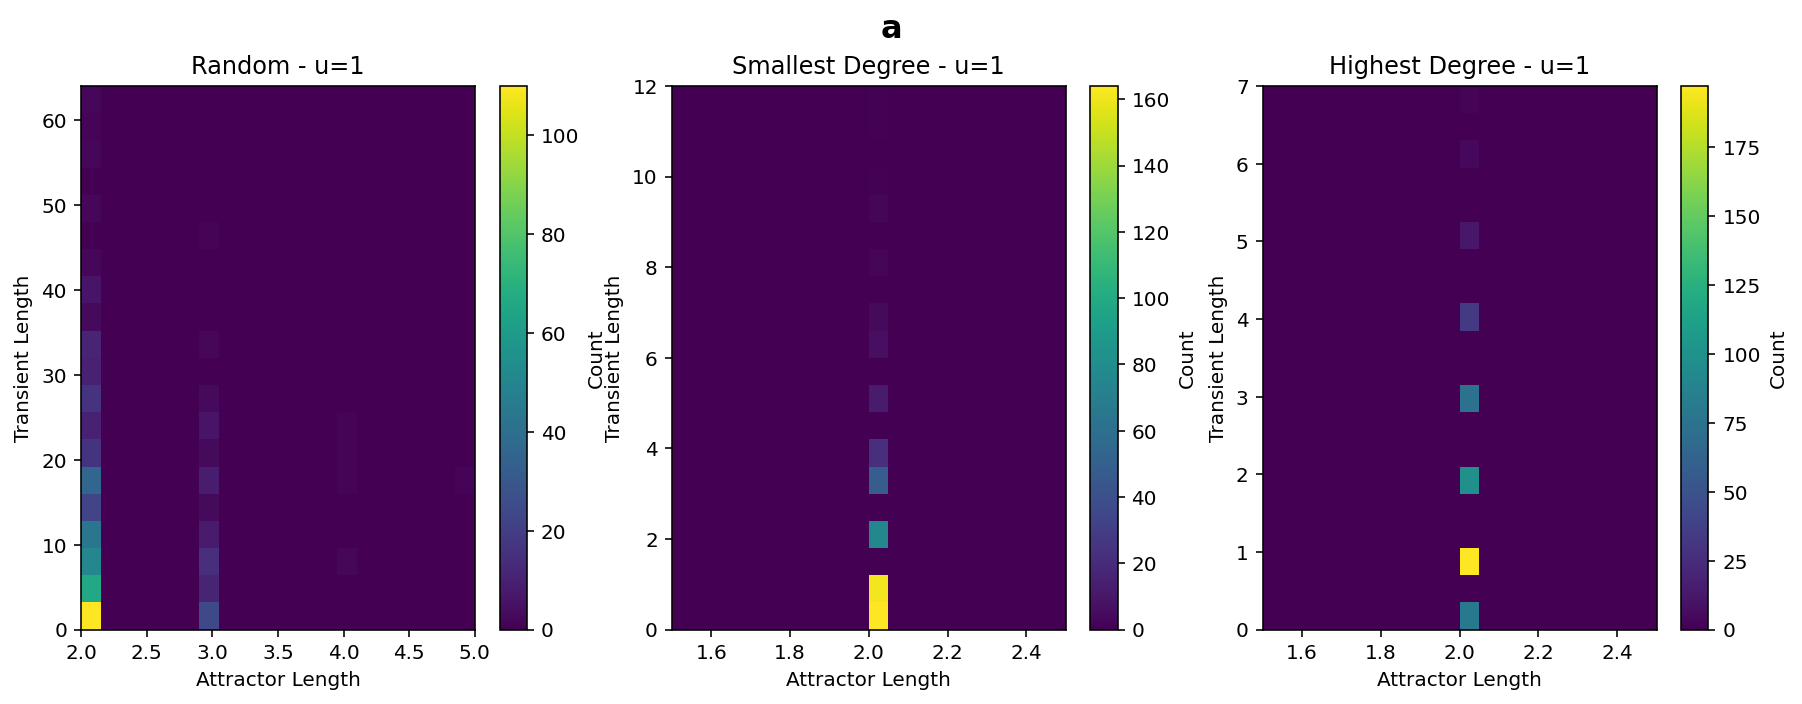

In [280]:
plot_histograms(results_u1_random, results_u1_smallest, results_u1_highest, "a", "1")

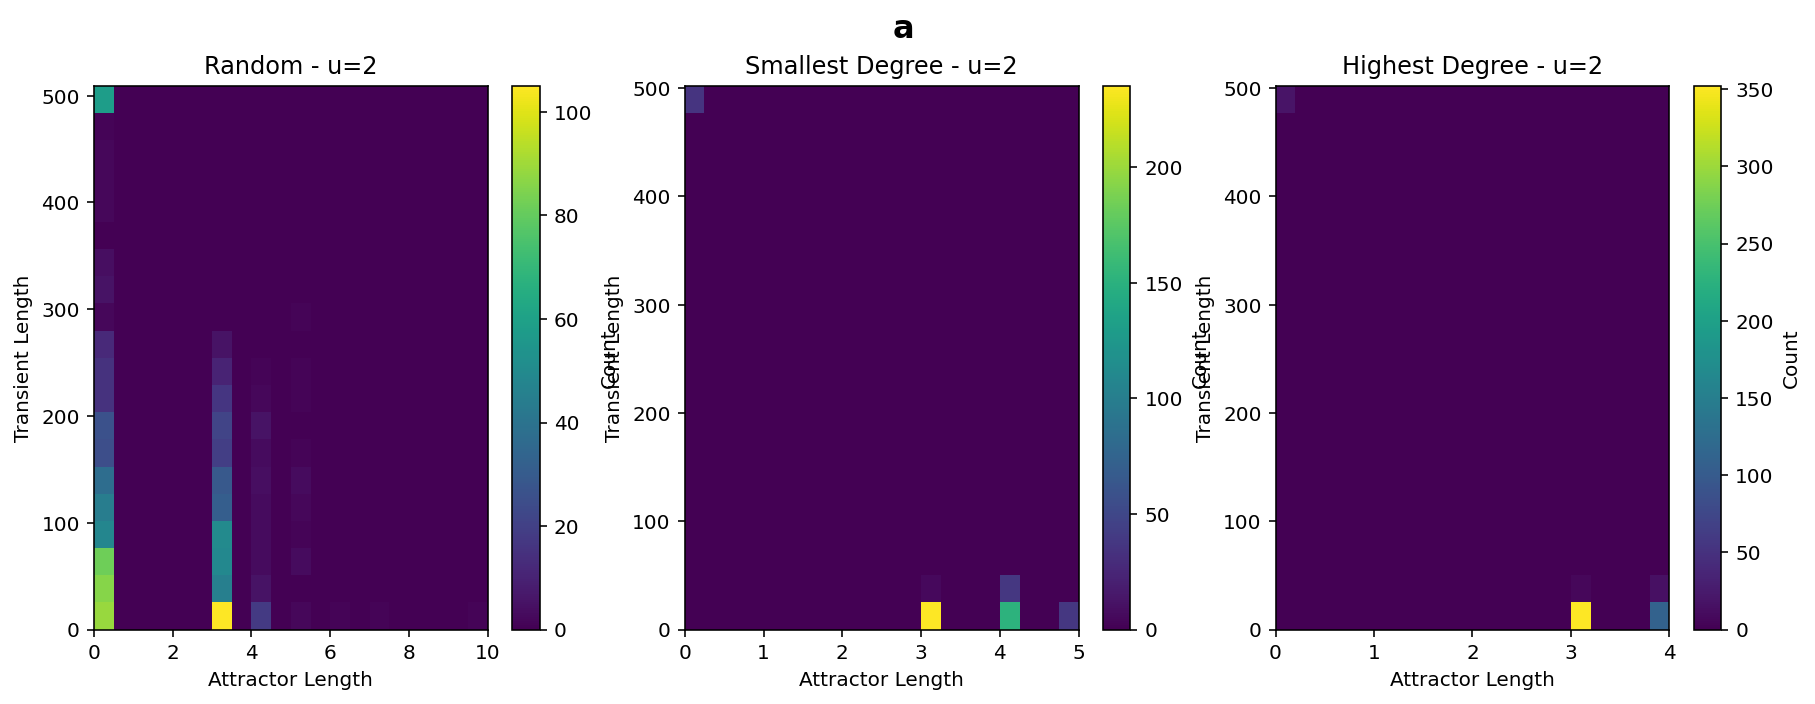

In [283]:
plot_histograms(results_u2_random, results_u2_smallest, results_u2_highest, "a", "2")

In [284]:
plot_histograms(results_u9_random, results_u9_smallest, results_u9_highest, "a", "9")

## Feature Vector

In [26]:
def estimate_caracteristic_vector(generate_histograms, memory_size, z):
    
    caracteristic_vector = []
    for l in range(memory_size + 1, memory_size + z):
        caracteristic_vector.append(generate_histograms.count(l))  
    
    return caracteristic_vector

In [27]:
def generator_caracteristic_vector(results, memory_size, z):
    transient_lengths = []
    attractor_lengths = []
    
    for result in results:
        transient_lengths.append(len(result['transient']))
        attractor_lengths.append(len(result['attractor']))

    caracteristc_vector_transient = estimate_caracteristic_vector(transient_lengths, memory_size, z)
    caracteristic_vector_attractor = estimate_caracteristic_vector(attractor_lengths, memory_size, z)

    return caracteristc_vector_transient, caracteristic_vector_attractor

### Evaluating the Tourist function

(0.0, 20.0)

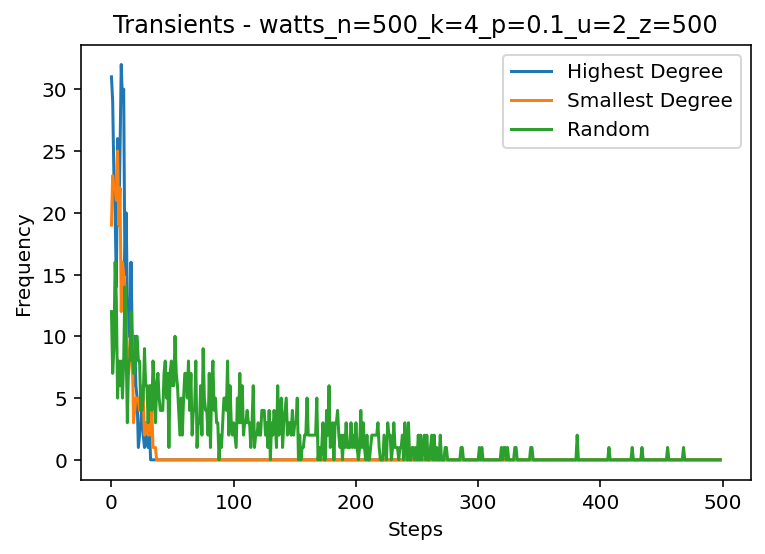

In [292]:
plt.figure()
plt.plot(generator_caracteristic_vector(results_u2_highest, 2, 500)[0], label="Highest Degree")
plt.plot(generator_caracteristic_vector(results_u2_smallest, 2, 500)[0], label="Smallest Degree")
plt.plot(generator_caracteristic_vector(results_u2_random, 2, 500)[0], label="Random")
plt.legend()
plt.title("Transients - watts_n=500_k=4_p=0.1_u=2_z=500")
plt.xlabel("Steps")
plt.ylabel("Frequency")

plt.figure()
plt.plot(generator_caracteristic_vector(results_u2_highest, 2, 500)[1], label="Highest Degree")
plt.plot(generator_caracteristic_vector(results_u2_smallest, 2, 500)[1], label="Smallest Degree")
plt.plot(generator_caracteristic_vector(results_u2_random, 2, 500)[1], label="Random")
plt.legend()
plt.title("Attractors - watts_n=500_k=4_p=0.1_u=2_z=500")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.xlim(0, 20)

(0.0, 20.0)

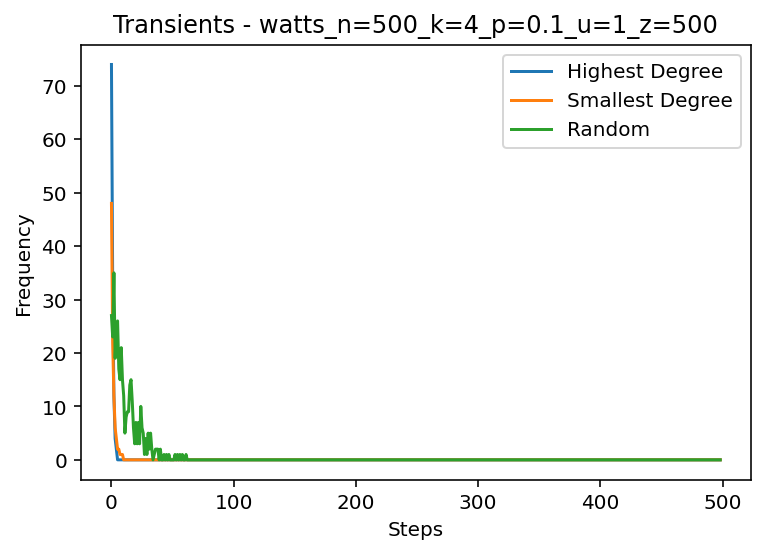

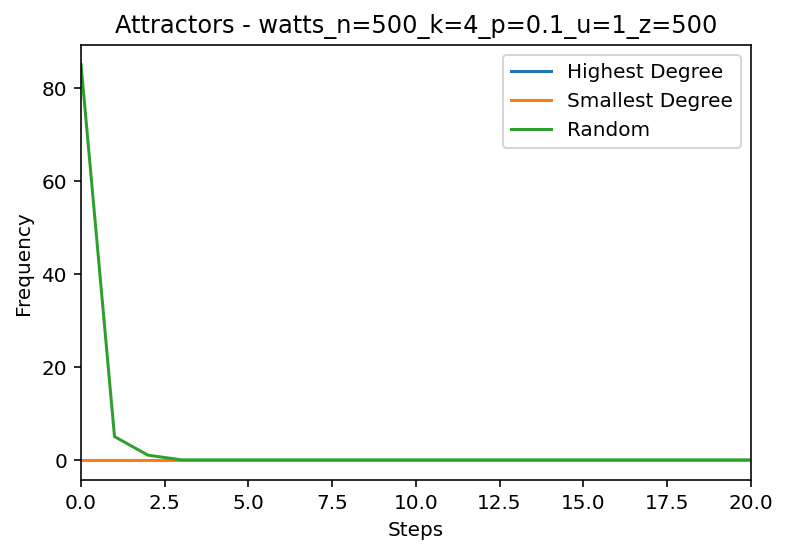

In [290]:
plt.figure()
plt.plot(generator_caracteristic_vector(results_u1_highest, 2, 500)[0], label="Highest Degree")
plt.plot(generator_caracteristic_vector(results_u1_smallest, 2, 500)[0], label="Smallest Degree")
plt.plot(generator_caracteristic_vector(results_u1_random, 2, 500)[0], label="Random")
plt.legend()
plt.title("Transients - watts_n=500_k=4_p=0.1_u=1_z=500")
plt.xlabel("Steps")
plt.ylabel("Frequency")

plt.figure()
plt.plot(generator_caracteristic_vector(results_u1_highest, 2, 500)[1], label="Highest Degree")
plt.plot(generator_caracteristic_vector(results_u1_smallest, 2, 500)[1], label="Smallest Degree")
plt.plot(generator_caracteristic_vector(results_u1_random, 2, 500)[1], label="Random")
plt.legend()
plt.title("Attractors - watts_n=500_k=4_p=0.1_u=1_z=500")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.xlim(0, 20)

## Comparing Network Types

In [294]:
watts_1 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=5.txt")
watts_2 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=10.txt")
watts_3 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=15.txt")
watts_4 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=20.txt")
watts_5 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=25.txt")

erdos_1 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/erdos_n=500_k=4_i=5.txt")
erdos_2 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/erdos_n=500_k=4_i=10.txt")
erdos_3 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/erdos_n=500_k=4_i=15.txt")
erdos_4 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/erdos_n=500_k=4_i=20.txt")
erdos_5 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/erdos_n=500_k=4_i=25.txt")

geo_1 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/geo_n=500_k=4_i=5.txt")
geo_2 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/geo_n=500_k=4_i=10.txt")
geo_3 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/geo_n=500_k=4_i=15.txt")
geo_4 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/geo_n=500_k=4_i=20.txt")
geo_5 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/geo_n=500_k=4_i=25.txt")

barabasi_1 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/barabasi_n=500_k=4_i=5.txt")
barabasi_2 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/barabasi_n=500_k=4_i=10.txt")
barabasi_3 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/barabasi_n=500_k=4_i=15.txt")
barabasi_4 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/barabasi_n=500_k=4_i=20.txt")
barabasi_5 = open_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/barabasi_n=500_k=4_i=25.txt")

In [295]:
watts_networks = [watts_1, watts_2, watts_3, watts_4, watts_5]
erdos_networks = [erdos_1, erdos_2, erdos_3, erdos_4, erdos_5]
geo_networks = [geo_1, geo_2, geo_3, geo_4, geo_5]
barabasi_networks = [barabasi_1, barabasi_2, barabasi_3, barabasi_4, barabasi_5]

AgentClass = TouristSmallestDegree
u_1 = 2
z_1 = 600

watts_hists = []
erdos_hists = []
geo_hists = []
barabasi_hists = []

for network in watts_networks:
    result_watts = []
    
    for node in network.nodes():
        agent = AgentClass(network, node, u=u_1, z=z_1)
        result_watts.append(agent.run())

    watts_hists.append(generator_caracteristic_vector(result_watts, u_1, z_1))

for network in erdos_networks:
    result_erdos = []
    
    for node in network.nodes():
        agent = AgentClass(network, node, u=u_1, z=z_1)
        result_erdos.append(agent.run())

    erdos_hists.append(generator_caracteristic_vector(result_erdos, u_1, z_1))

for network in geo_networks:
    result_geo = []
    
    for node in network.nodes():
        agent = AgentClass(network, node, u=u_1, z=z_1)
        result_geo.append(agent.run())

    geo_hists.append(generator_caracteristic_vector(result_geo, u_1, z_1))

for network in barabasi_networks:
    result_barabasi = []
    
    for node in network.nodes():
        agent = AgentClass(network, node, u=u_1, z=z_1)
        result_barabasi.append(agent.run())

    barabasi_hists.append(generator_caracteristic_vector(result_barabasi, u_1, z_1))

## LDA Classification

In [58]:
class Classification:
    @staticmethod
    def load_network(file_path):
        f = open(file_path, "r")
        lines = f.read().split("\n")

        R = nx.Graph()
        for line in lines:
            network_array = line.split(" ")
            for x in network_array[1:]:
                R.add_edge(network_array[0], x)
        return R

    @staticmethod
    def calculate_features(graph, tourist):
        tourist.run()
        mean_transient = np.mean([len(t) for t in tourist.transient]) if len(tourist.transient) > 0 else 0
        std_transient = np.std([len(t) for t in tourist.transient]) if len(tourist.transient) > 0 else 0
        mean_attractor = np.mean([len(a) for a in tourist.attractor]) if len(tourist.attractor) > 0 else 0
        std_attractor = np.std([len(a) for a in tourist.attractor]) if len(tourist.attractor) > 0 else 0
        return [mean_transient, std_transient, mean_attractor, std_attractor], tourist.transient, tourist.attractor

    @staticmethod
    def learning_networks(tourist_class, u=1, z=500):
        network_files = [
            "barabasi_n=500_k=4_i=" + str(i) + ".txt" for i in range(1,91)
        ] +[
            "watts_n=500_k=4_p=0.1_i=" + str(i) + ".txt" for i in range(1,91)
        ] +[
            "erdos_n=500_k=4_i=" + str(i) + ".txt" for i in range(1,91)
        ] +[
            "geo_n=500_k=4_i=" + str(i) + ".txt" for i in range(1,91)
        ]
        
        feature_vectors = []
        labels = []

        for network_file in tqdm(network_files):
            R = Classification.load_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/" + network_file)
            for node in R.nodes():  
                tourist = tourist_class(R, node, u=u, z=z)
                features, transients, attractors = Classification.calculate_features(R, tourist)
            
                feature_vectors.append(features)
                labels.append(network_file.split("/")[-1].split("_")[0]) 
                
                
        X = np.array(feature_vectors)
        y = np.array(labels)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)

        accuracy = lda.score(X_test, y_test)
        print(f'{accuracy:.4f}')
        
        return lda

## Training the three cases:

### - Smallest,  - Highest,  - Random

In [59]:
classifier_smallest_u1 = Classification().learning_networks(TouristSmallestDegree, u=1, z=500)
classifier_highest_u1 = Classification().learning_networks(TouristHighestDegree, u=1, z=500)
classifier_random_u1 = Classification().learning_networks(Tourist, u=1, z=500)

100%|█████████████████████████████████████████| 360/360 [00:16<00:00, 22.21it/s]


0.3897


100%|█████████████████████████████████████████| 360/360 [00:36<00:00,  9.83it/s]


0.5678


100%|█████████████████████████████████████████| 360/360 [02:02<00:00,  2.93it/s]


0.5189


In [60]:
classifier_smallest_u2 = Classification().learning_networks(TouristSmallestDegree, u=2, z=500)
classifier_highest_u2 = Classification().learning_networks(TouristHighestDegree, u=2, z=500)
classifier_random_u2 = Classification().learning_networks(Tourist, u=2, z=500)

100%|█████████████████████████████████████████| 360/360 [03:47<00:00,  1.58it/s]


0.6667


100%|█████████████████████████████████████████| 360/360 [06:27<00:00,  1.08s/it]


0.6194


100%|█████████████████████████████████████████| 360/360 [47:26<00:00,  7.91s/it]


0.7010


In [61]:
classifier_smallest_u9 = Classification().learning_networks(TouristSmallestDegree, u=9, z=500)
classifier_highest_u9 = Classification().learning_networks(TouristHighestDegree, u=9, z=500)
classifier_random_u9 = Classification().learning_networks(Tourist, u=9, z=500)

100%|█████████████████████████████████████████| 360/360 [02:41<00:00,  2.23it/s]


0.5918


100%|█████████████████████████████████████████| 360/360 [13:32<00:00,  2.26s/it]


0.5786


100%|█████████████████████████████████████████| 360/360 [03:35<00:00,  1.67it/s]


0.5359


In [168]:
TESTE = Classification.load_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=100.txt" )

feature_vectors_Smallest = []

for node in TESTE.nodes():  
    tourist = TouristSmallestDegree(TESTE, node, u=9, z=500)
    features, trans, att = Classification.calculate_features(TESTE, tourist)
    feature_vectors_Smallest.append(features)

predictions_for_smallest = classifier_highest_u9.predict(feature_vectors_Smallest)

In [169]:
TESTE = Classification.load_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=100.txt" )

feature_vectors_highest = []

for node in TESTE.nodes():  
    tourist = TouristHighestDegree(TESTE, node, u=9, z=500)
    features, trans, att = Classification.calculate_features(TESTE, tourist)
    feature_vectors_highest.append(features)
    
predictions_for_highest = classifier_highest_u9.predict(feature_vectors_highest)

In [170]:
TESTE = Classification.load_network("./RedesComplexas_2semestre_2024/synthetic_model/graphs/watts_n=500_k=4_p=0.1_i=100.txt" )

feature_vectors_random = []

for node in TESTE.nodes():  
    tourist = Tourist(TESTE, node, u=9, z=500)
    features, trans, att = Classification.calculate_features(TESTE, tourist)
    feature_vectors_random.append(features)
    
predictions_for_random = classifier_random_u9.predict(feature_vectors_random)

In [103]:
def plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, title, subtitle):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    fig.suptitle(title, fontsize=16, fontweight='bold')

    fig.text(0.5, -0.02, subtitle, fontsize=15, fontweight='bold', ha='center')

    axes[0].hist(predictions_for_smallest, bins=np.arange(len(set(predictions_for_smallest)) + 1) - 0.5, color='skyblue', edgecolor='black')
    axes[0].set_title("Smallest Degree", fontsize=15)
    axes[0].set_xlabel("Classes", fontsize=14)
    axes[0].set_ylabel("Frequency", fontsize=14)
    axes[0].set_xticks(['barabasi', 'erdos', 'geo', 'watts'])
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].hist(predictions_for_highest, bins=np.arange(len(set(predictions_for_highest)) + 1) - 0.5, color='salmon', edgecolor='black')
    axes[1].set_title("Highest Degree", fontsize=15)
    axes[1].set_xlabel("Classes", fontsize=14)
    axes[1].set_xticks(['barabasi', 'erdos', 'geo', 'watts'])
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    axes[2].hist(predictions_for_random, bins=np.arange(len(set(predictions_for_random)) + 1) - 0.5, color='lightgreen', edgecolor='black')
    axes[2].set_title("Random", fontsize=15)
    axes[2].set_xlabel("Classes", fontsize=14)
    axes[2].set_xticks(['barabasi', 'erdos', 'geo', 'watts'])
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para acomodar o título principal e subtítulo
    plt.show()

# Results

# u = 1

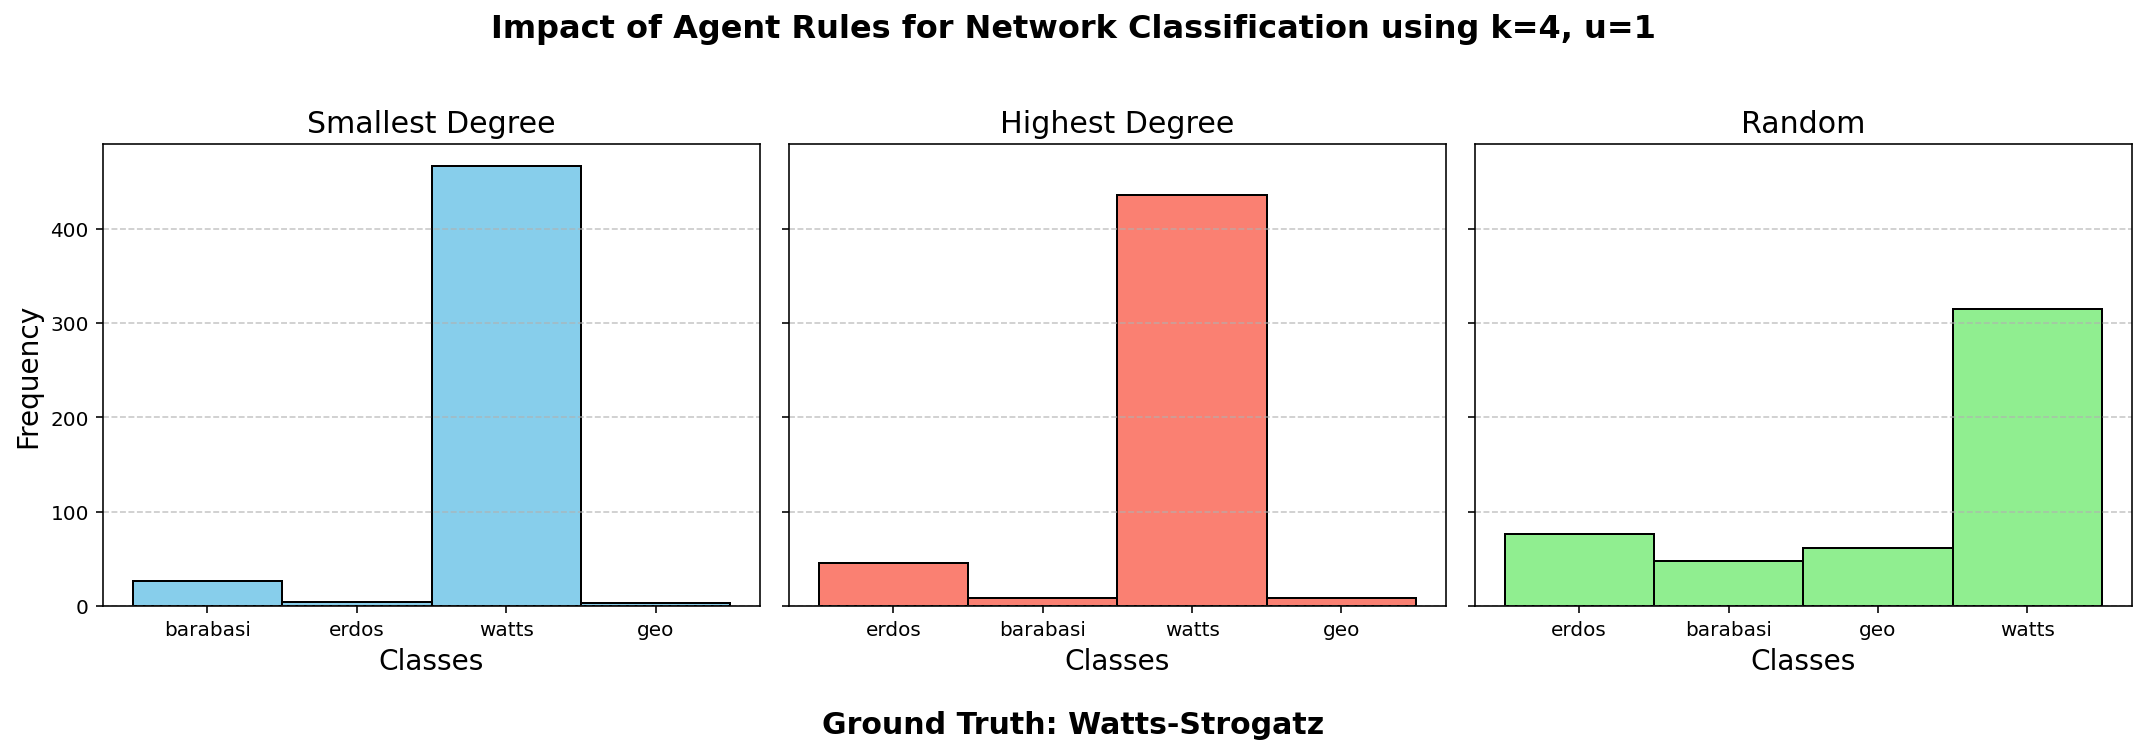

In [131]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=1", "Ground Truth: Watts-Strogatz")

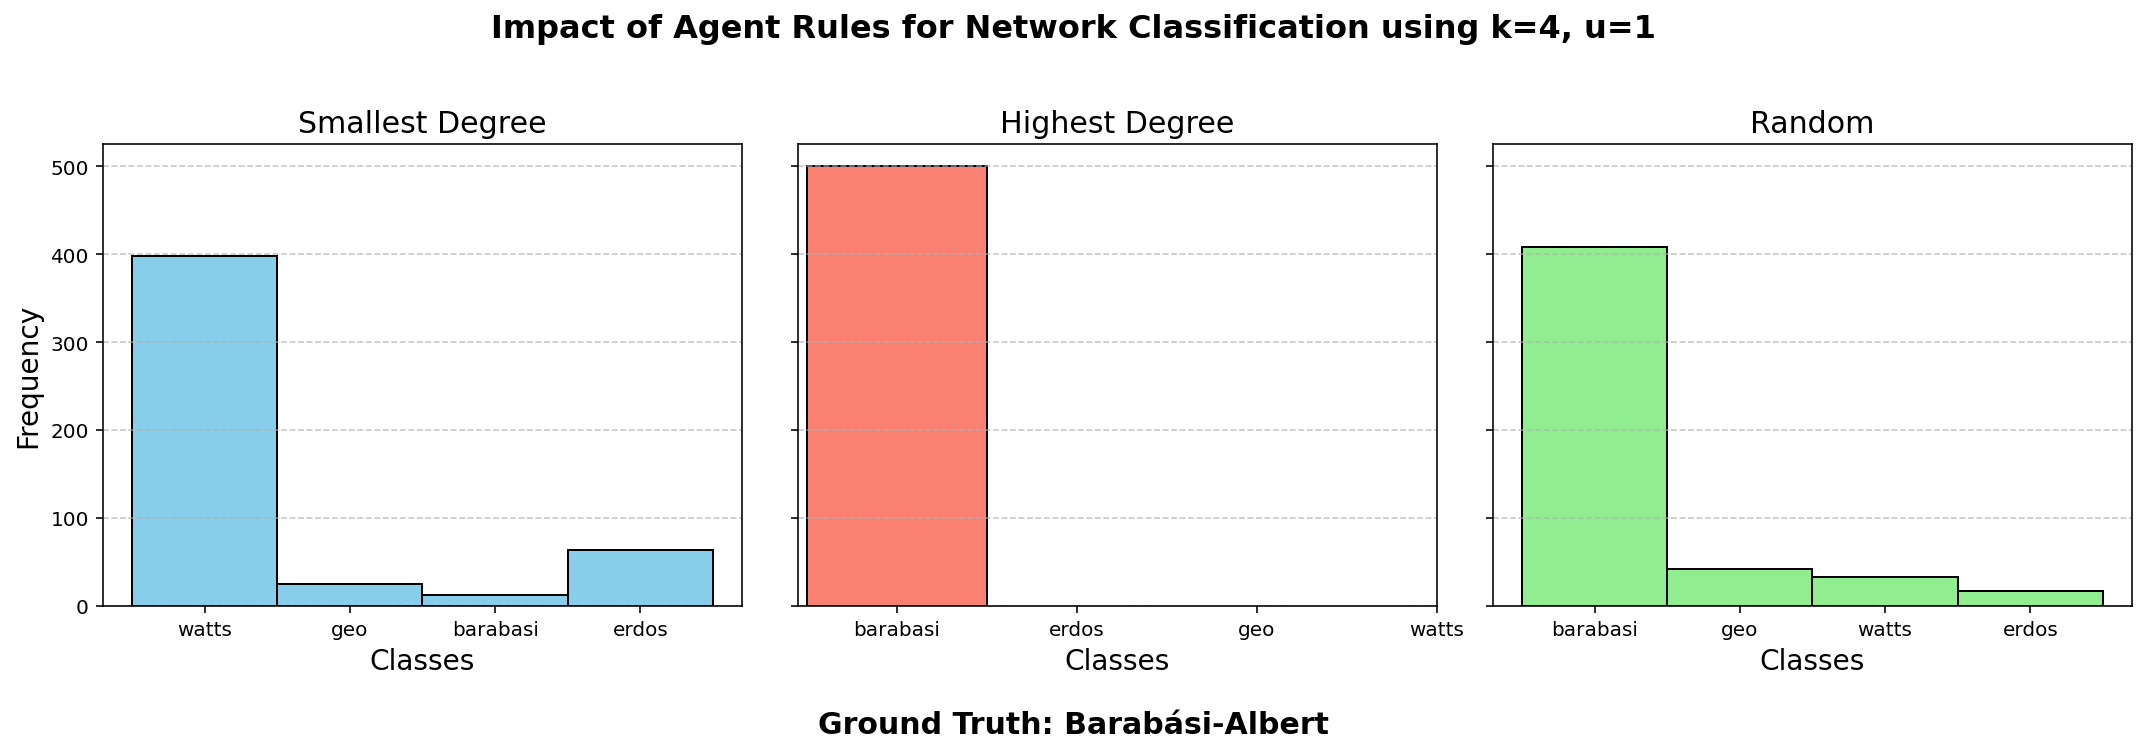

In [113]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=1", "Ground Truth: Barabási-Albert")

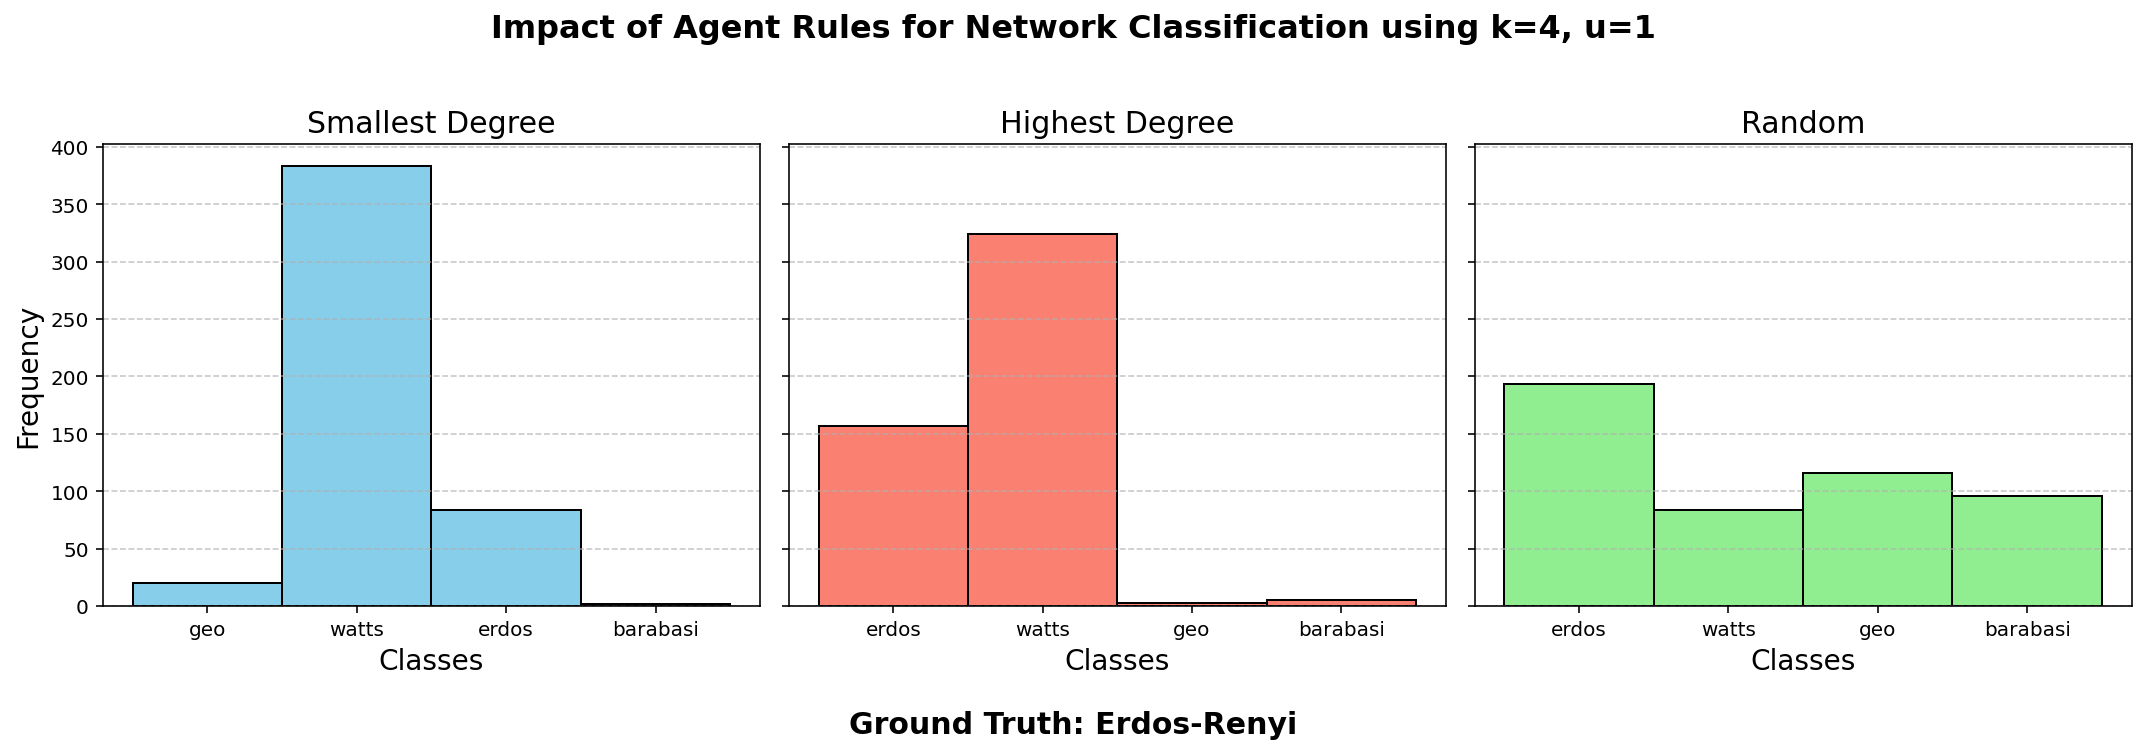

In [123]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=1", "Ground Truth: Erdos-Renyi")

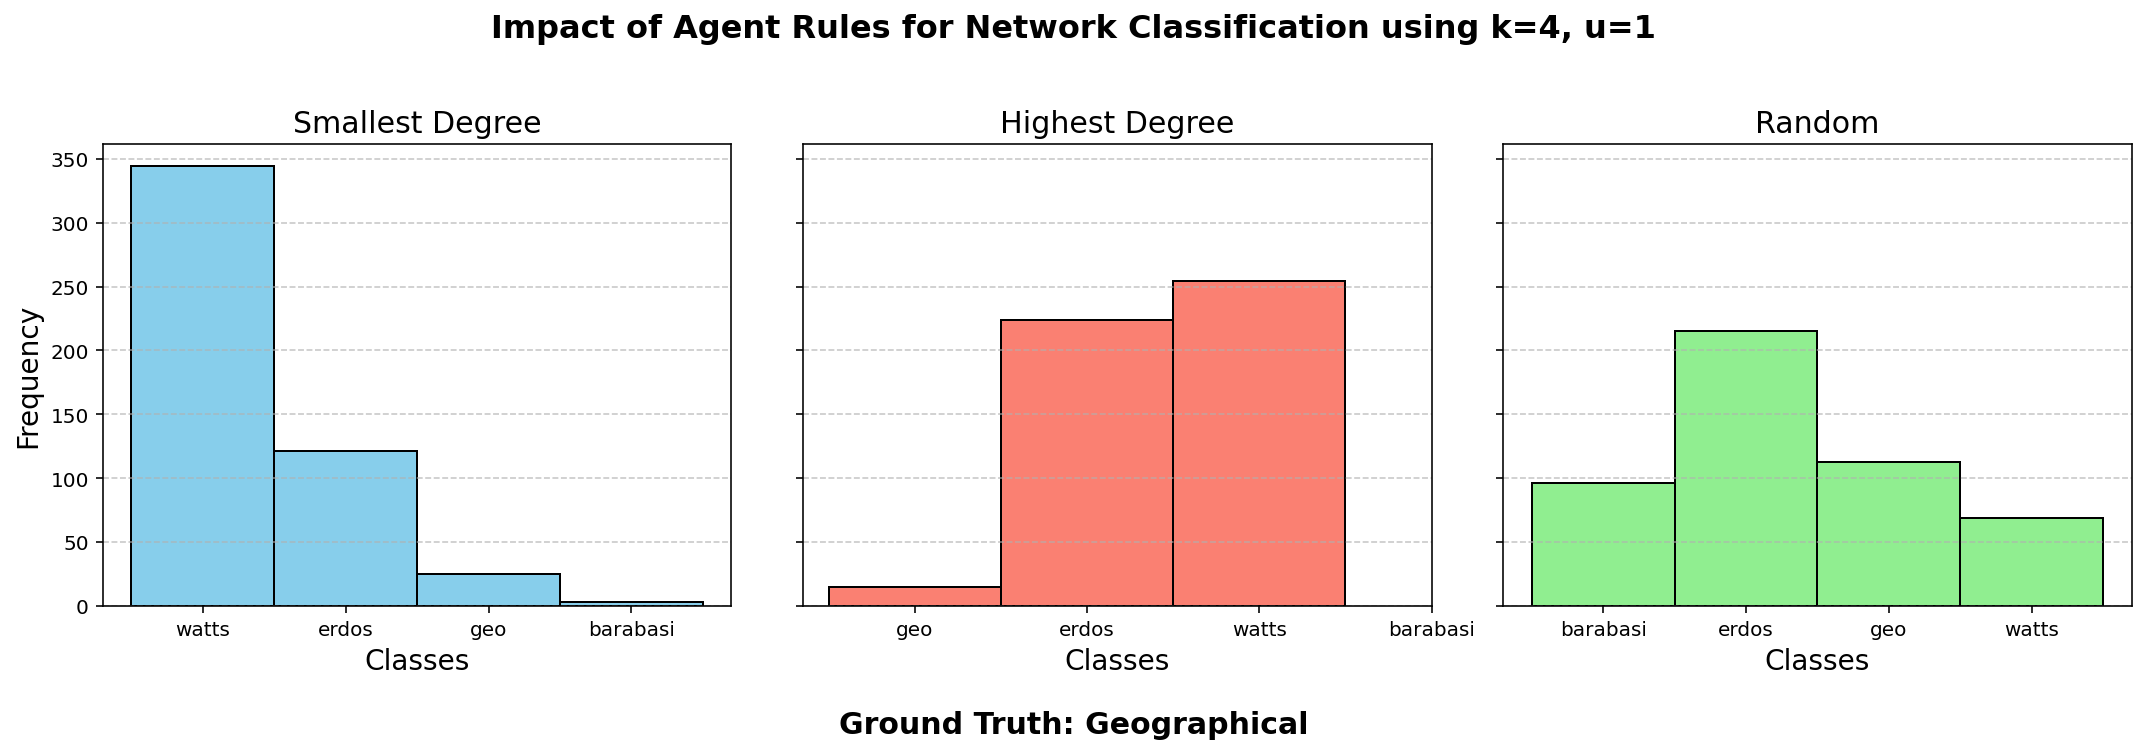

In [127]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=1", "Ground Truth: Geographical")

# u = 2

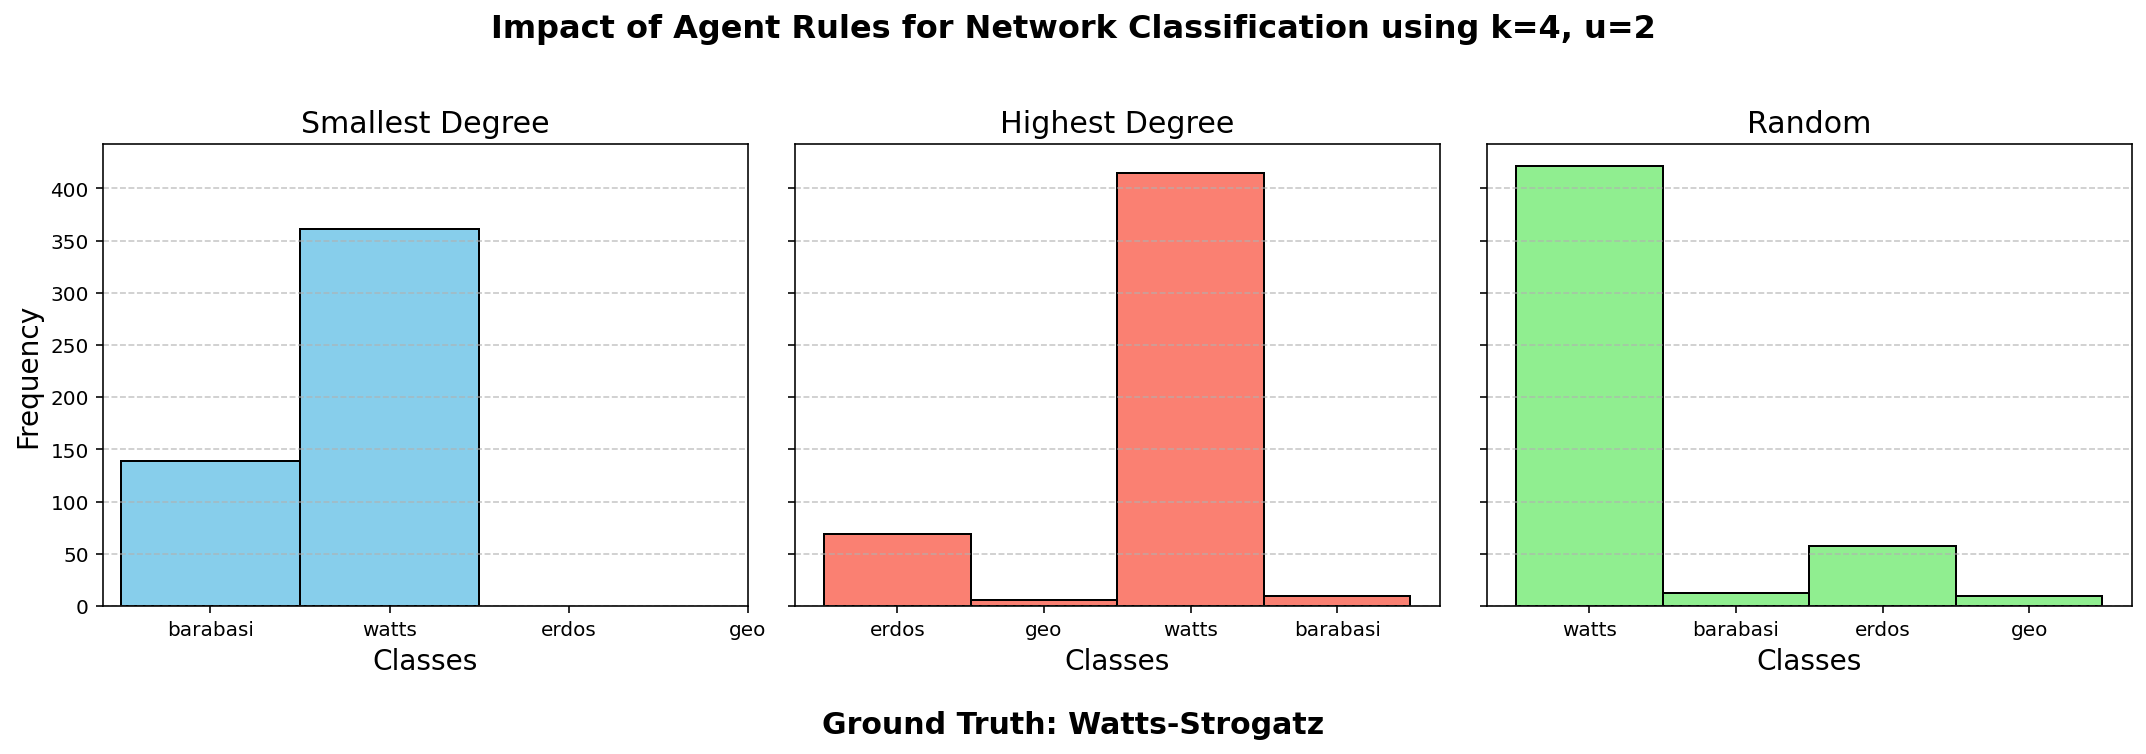

In [135]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=2", "Ground Truth: Watts-Strogatz")

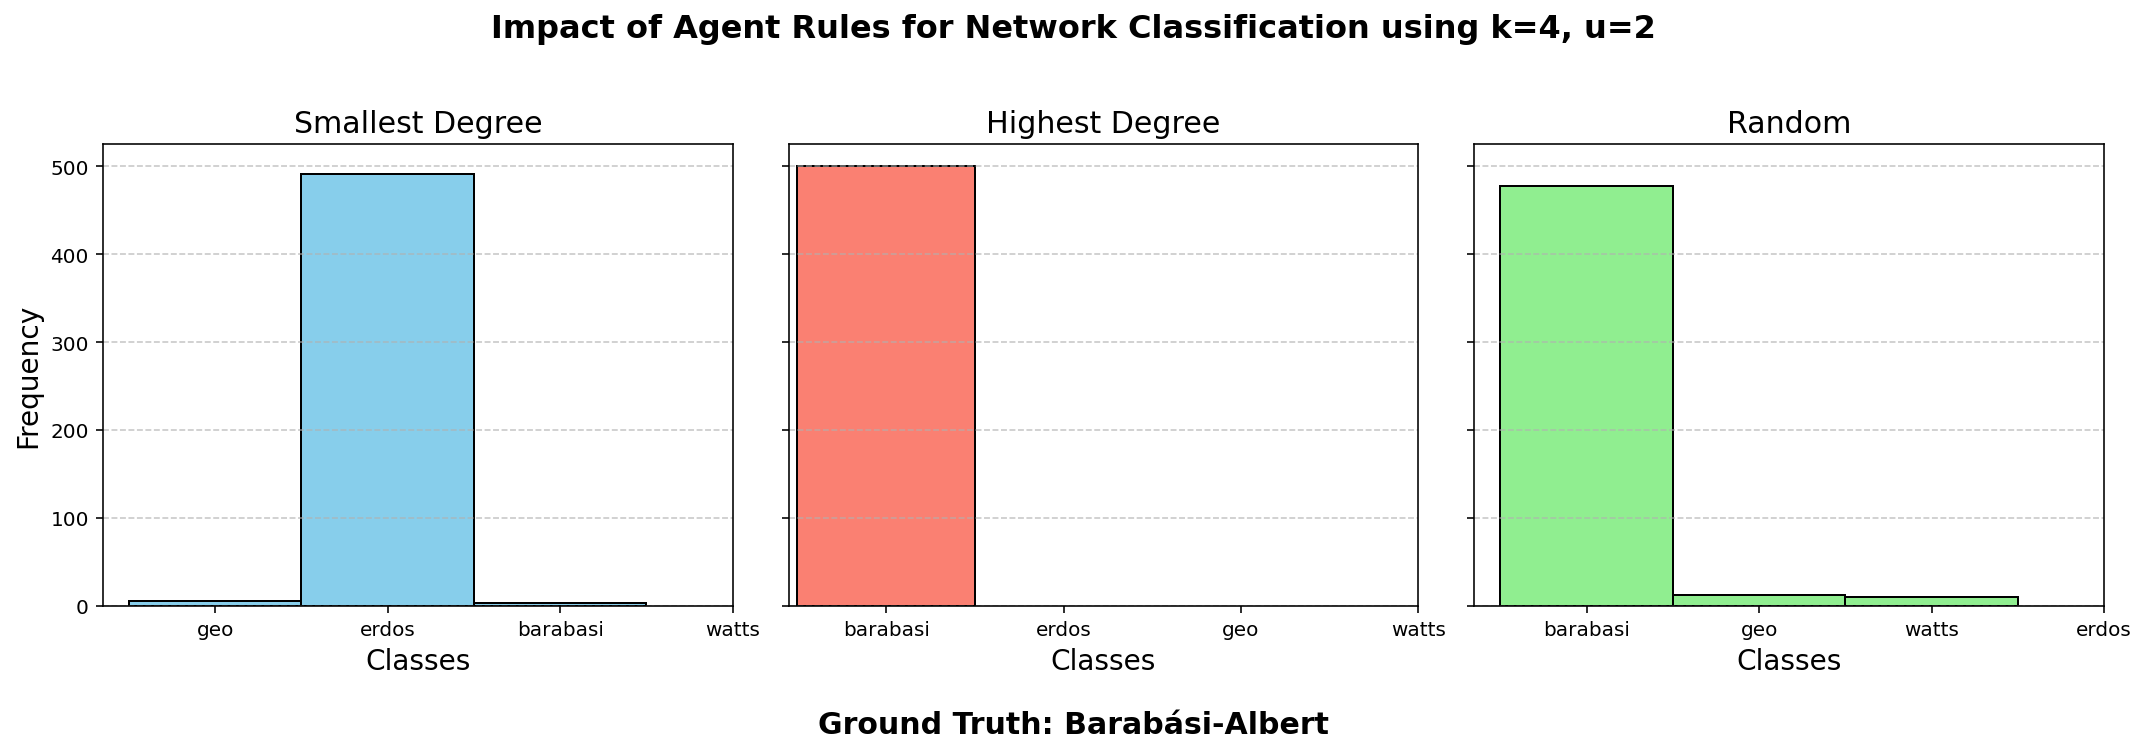

In [139]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=2", "Ground Truth: Barabási-Albert")

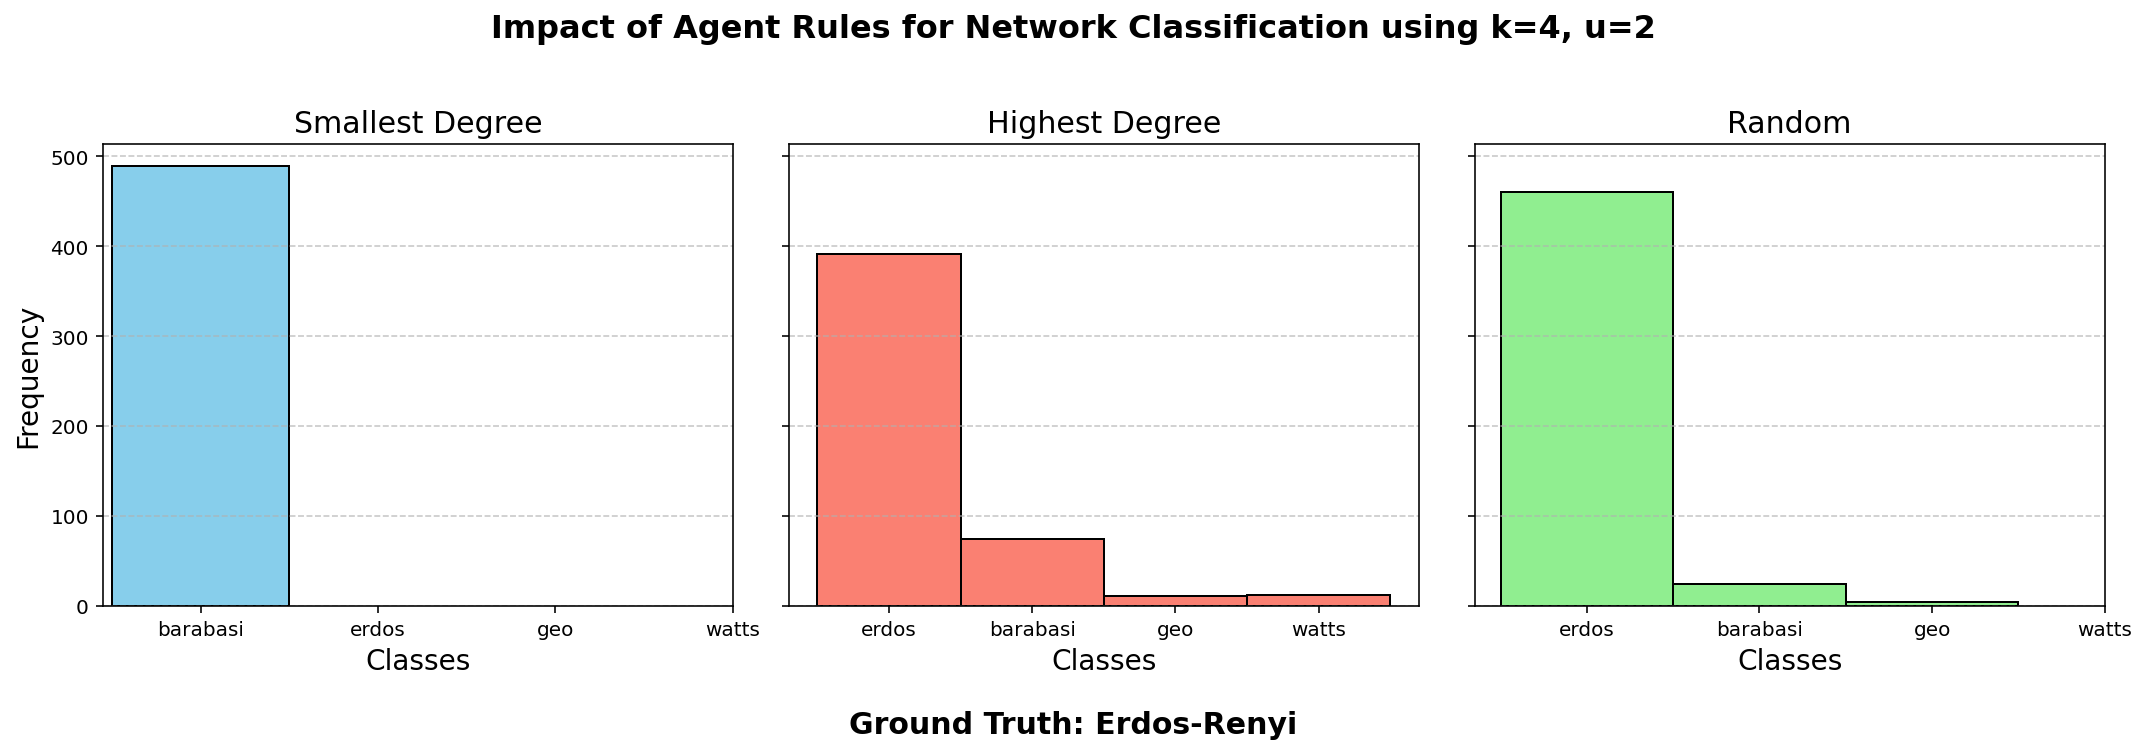

In [143]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=2", "Ground Truth: Erdos-Renyi")

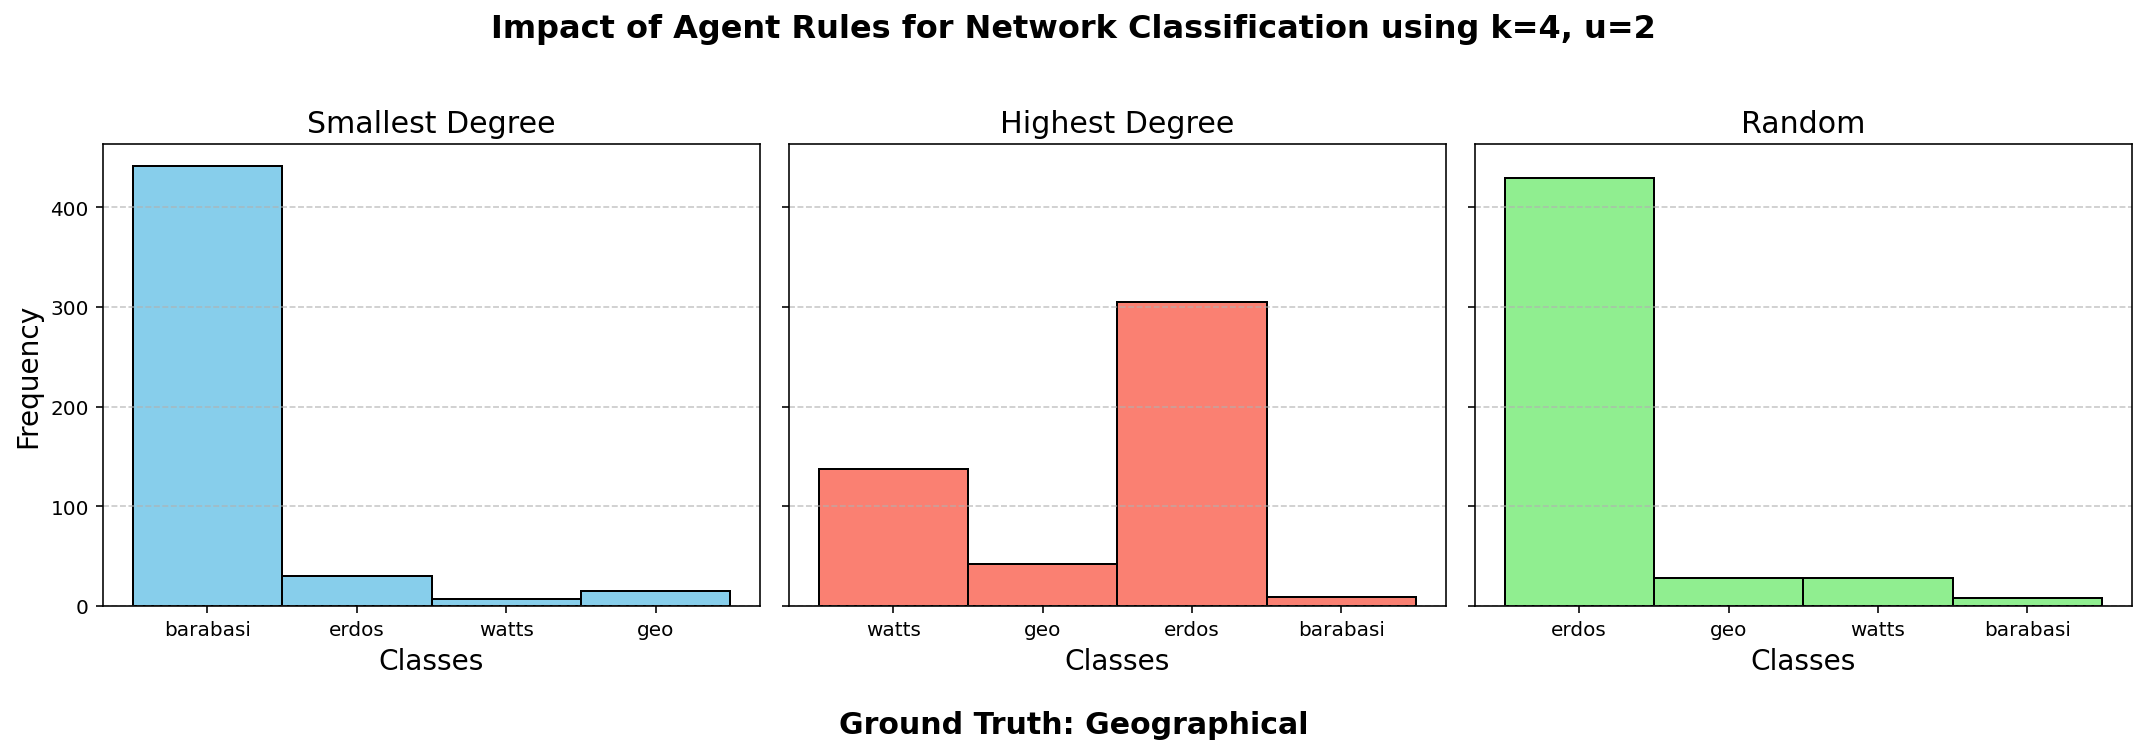

In [147]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=2", "Ground Truth: Geographical")

# u = 9

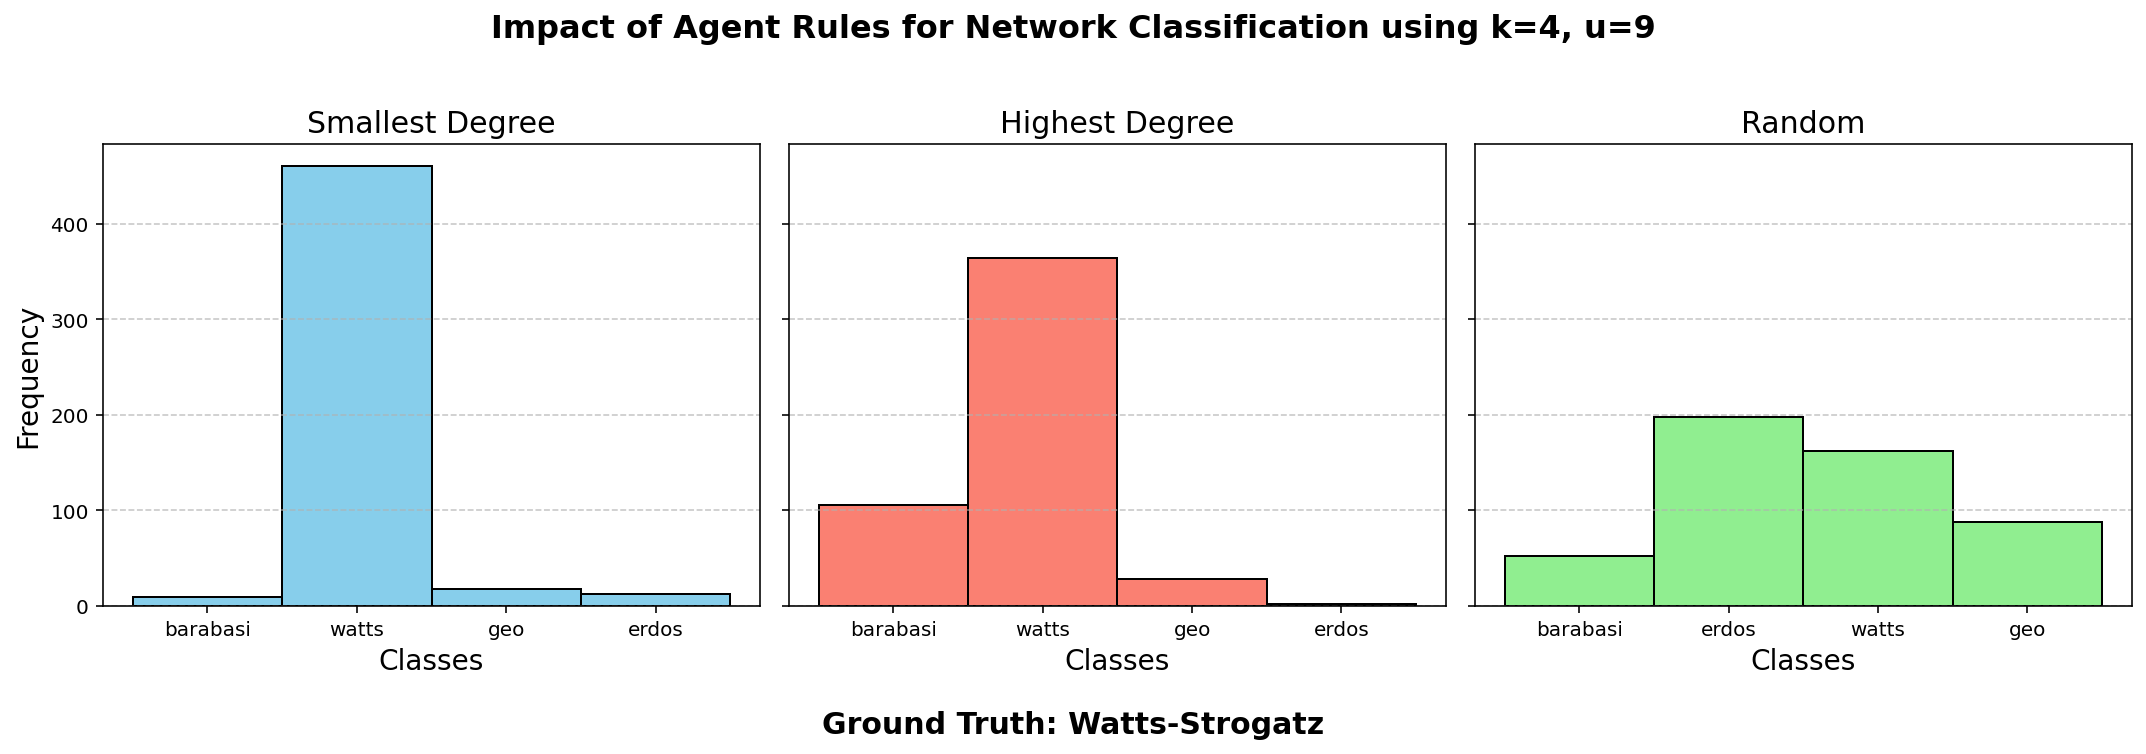

In [172]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=9", "Ground Truth: Watts-Strogatz")

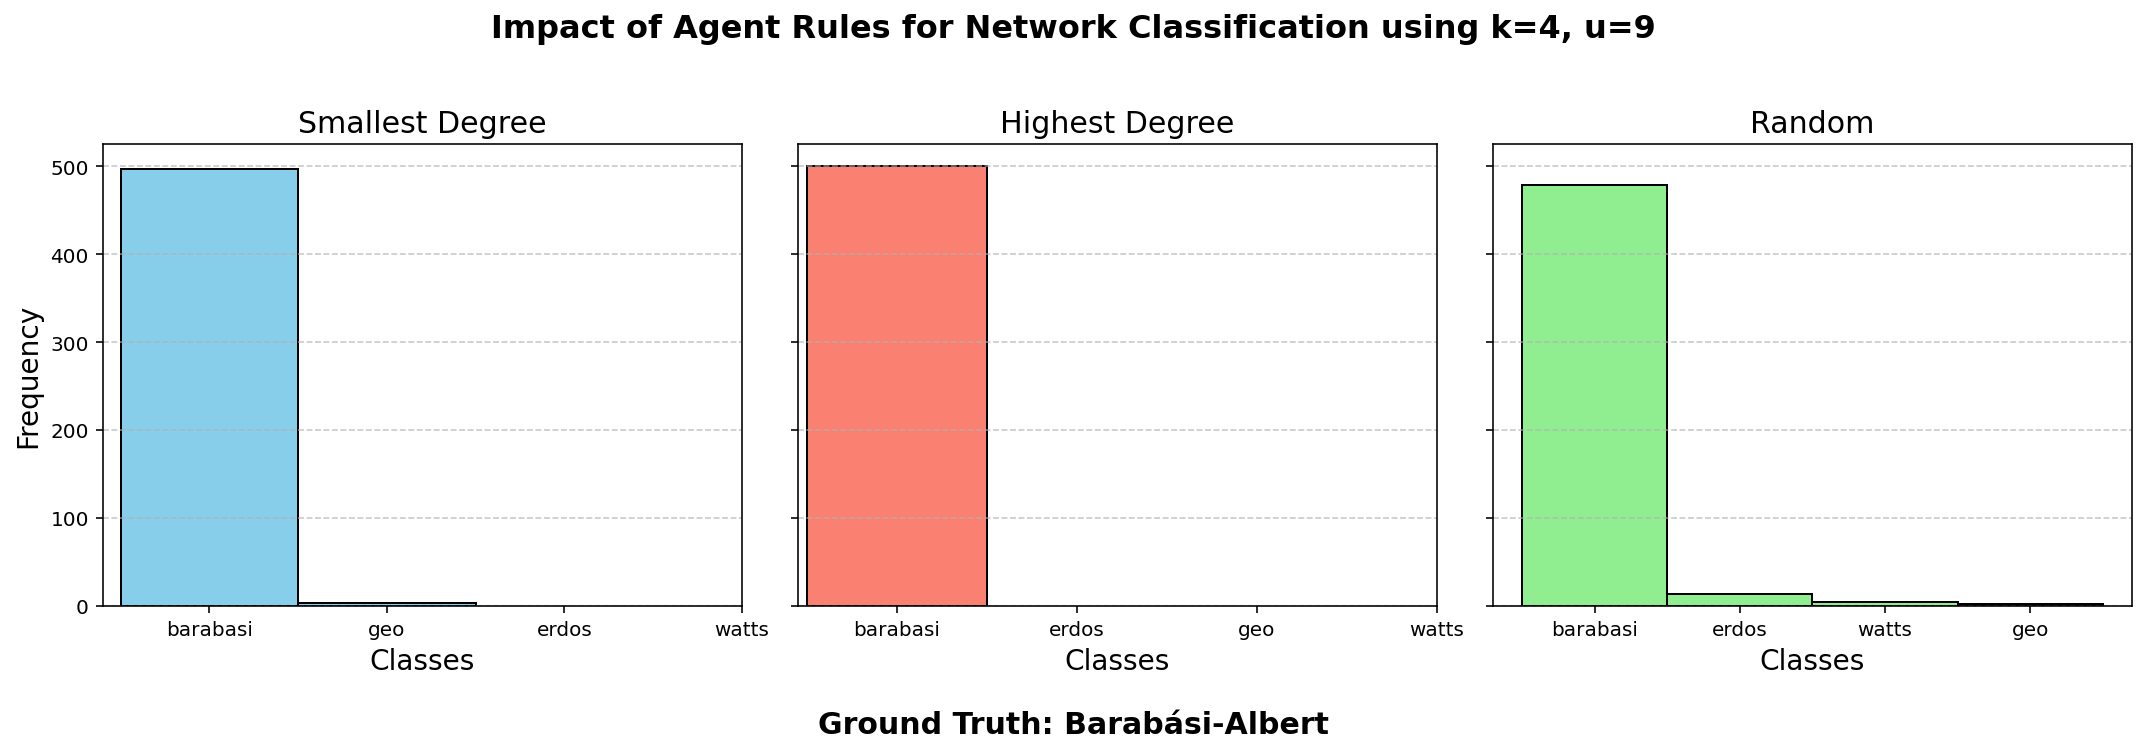

In [158]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=9", "Ground Truth: Barabási-Albert")

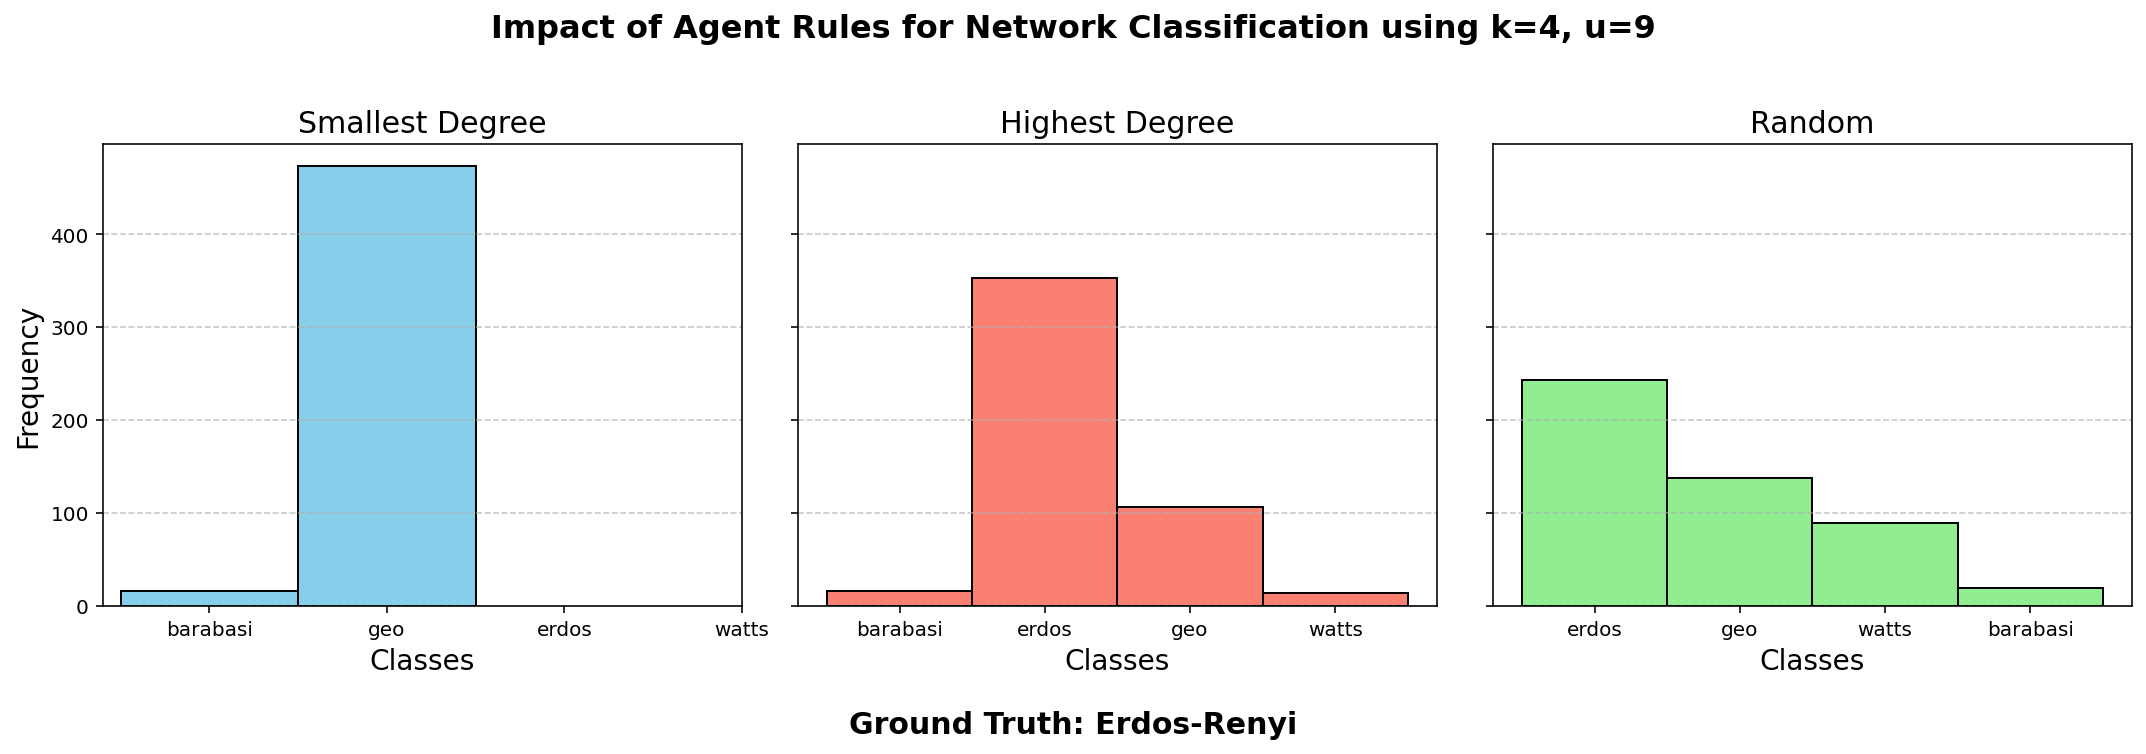

In [162]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=9", "Ground Truth: Erdos-Renyi")

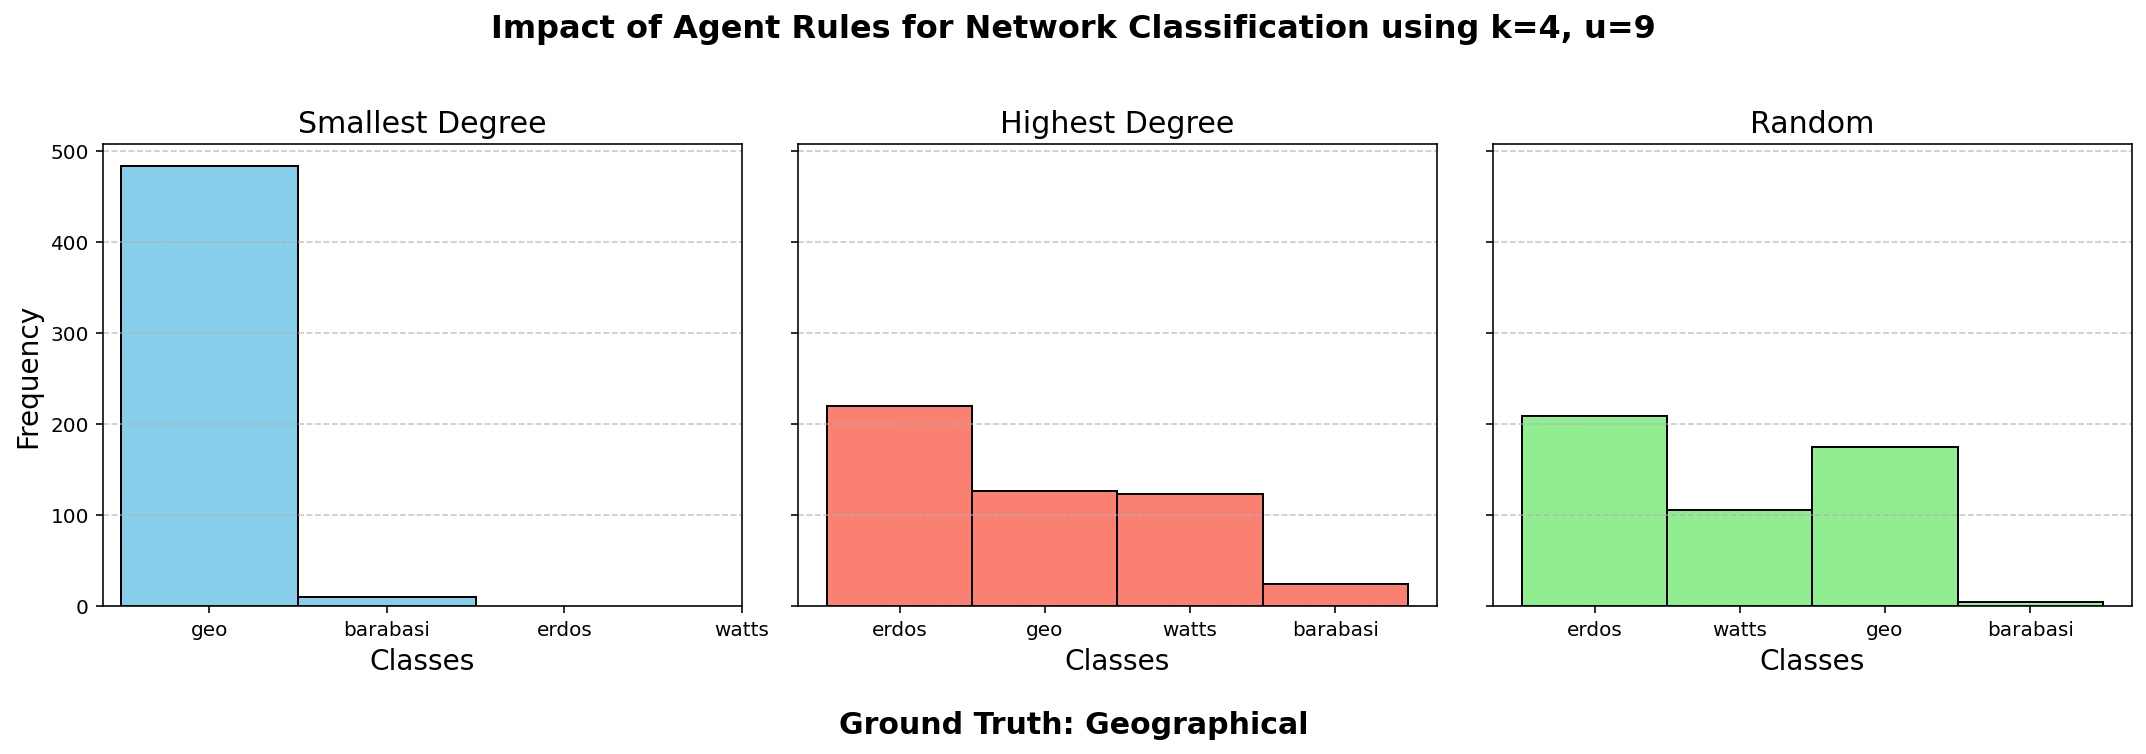

In [167]:
plot_graphics(predictions_for_smallest, predictions_for_highest, predictions_for_random, 
              "Impact of Agent Rules for Network Classification using k=4, u=9", "Ground Truth: Geographical")